In [1]:
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
import torch
import itertools
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter, LogFormatter
import os 
from ase.io import read
from mace.data import utils  # adjust if your package path differs
from mace.tools import torch_tools  # adjust if needed
from mace.tools import torch_geometric, torch_tools, utils
from mace.cli.convert_e3nn_cueq import run as run_e3nn_to_cueq
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'
from mace import data

/home/brad/miniconda3/envs/mace-field/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


In [3]:
!mace_eval_configs --configs "data/dielectric-train.xyz" --model "mace-field-mp-0b3-medium-mh.model" --output "inference/dielectric-train-MACE-mh.xyz" --head "pt_head" --compute_becs --compute_polarisability --compute_energy --compute_force --compute_polarisation --compute_stress --default_dtype "float32"
!mace_eval_configs --configs "data/dielectric-valid.xyz" --model "mace-field-mp-0b3-medium-mh.model" --output "inference/dielectric-valid-MACE-mh.xyz" --head "pt_head" --compute_becs --compute_polarisability --compute_energy --compute_force --compute_polarisation --compute_stress --default_dtype "float32"
!mace_eval_configs --configs "data/dielectric-test.xyz" --model "mace-field-mp-0b3-medium-mh.model" --output "inference/dielectric-test-MACE-mh.xyz" --head "pt_head" --compute_becs --compute_polarisability --compute_energy --compute_force --compute_polarisation --compute_stress --default_dtype "float32"
!mace_eval_configs --configs "data/ferroelectric-train.xyz" --model "mace-field-mp-0b3-medium-mh.model" --output "inference/ferroelectric-train-MACE-mh.xyz" --head "pt_head" --compute_becs --compute_polarisability --compute_energy --compute_force --compute_polarisation --compute_stress --default_dtype "float32"
!mace_eval_configs --configs "data/ferroelectric-valid.xyz" --model "mace-field-mp-0b3-medium-mh.model" --output "inference/ferroelectric-valid-MACE-mh.xyz" --head "pt_head" --compute_becs --compute_polarisability --compute_energy --compute_force --compute_polarisation --compute_stress --default_dtype "float32"
!mace_eval_configs --configs "data/ferroelectric-test.xyz" --model "mace-field-mp-0b3-medium-mh.model" --output "inference/ferroelectric-test-MACE-mh.xyz" --head "pt_head" --compute_becs --compute_polarisability --compute_energy --compute_force --compute_polarisation --compute_stress --default_dtype "float32"
!mace_eval_configs --configs "data/mp_traj_selected.xyz" --model "mace-field-mp-0b3-medium-mh.model" --output "inference/mp_traj_selected-MACE-mh.xyz" --head "pt_head" --compute_becs --compute_polarisability --compute_energy --compute_force --compute_polarisation --compute_stress --default_dtype "float32"

/home/brad/miniconda3/envs/mace-field/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/home/brad/repositories/mace-field/mace/cli/eval_configs.py:125: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)


In [2]:
MACE_traj_data = read("inference/mp_traj_selected-MACE-mh.xyz", ":")

MACE_dielectric_train_data = read("inference/dielectric-train-MACE-mh.xyz", ":")
MACE_dielectric_valid_data = read("inference/dielectric-valid-MACE-mh.xyz", ":")
MACE_dielectric_test_data = read("inference/dielectric-test-MACE-mh.xyz", ":")

MACE_ferroelectric_train_data = read("inference/ferroelectric-train-MACE-mh.xyz", ":")
MACE_ferroelectric_valid_data = read("inference/ferroelectric-valid-MACE-mh.xyz", ":")
MACE_ferroelectric_test_data = read("inference/ferroelectric-test-MACE-mh.xyz", ":")

In [46]:
MACE_energy = [atom.info["MACE_energy"] for atom in MACE_traj_data]
REF_energy = [atom.info["REF_energy"] for atom in MACE_traj_data]

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter, LogFormatter

def plot_energy_parity(
    REF, MACE, *,
    units="eV",
    gridsize=60,
    cmap="viridis",
    pct_limits=(1, 99),      # robust percentile limits
    symmetric=False,         # if True, enforce symmetric x/y limits about 0
    annotate="short",        # "none" | "short" | "long"
    figsize=(5.6, 5.4),
    lw_guide=1.2,
    lw_fit=1.4,
    title="Energy parity",
    xlabel=None,
    ylabel=None,
    cbar_label="log density",
):
    """
    Publication-ready energy parity using hexbin (log density) with a dedicated bottom colorbar.

    Parameters
    ----------
    REF, MACE : array-like, shape (N,)
        Reference and predicted energies.
    units : str
        Units string appended to axis labels (set "" to omit).
    pct_limits : (low, high)
        Percentiles in [0,100] for robust limits.
    symmetric : bool
        If True, make x/y limits symmetric about zero (like forces style). Otherwise use joint min–max.
    annotate : {"none","short","long"}
        Controls the stats box content.
    """

    REF = np.asarray(REF).reshape(-1)
    MACE = np.asarray(MACE).reshape(-1)

    # ---------- helpers ----------
    def stats(x, y):
        m, c = np.polyfit(x, y, 1)
        yhat = m * x + c
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        rmse = np.sqrt(np.mean((y - yhat) ** 2))
        mae  = np.mean(np.abs(y - x))
        return m, c, r2, rmse, mae

    def joint_limits(x, y, pct=(1, 99), symmetric=False):
        m = np.isfinite(x) & np.isfinite(y)
        if not np.any(m):
            return (-1.0, 1.0)
        xv = x[m]; yv = y[m]
        vals = np.r_[xv, yv]
        if symmetric:
            ql, qh = np.percentile(vals, pct)
            L = max(abs(ql), abs(qh))
            if not np.isfinite(L) or L == 0:  # fallback
                L = max(1.0, np.nanmax(np.abs(vals)))
            pad = 0.05 * L
            return (-(L + pad), (L + pad))
        else:
            lo, hi = np.percentile(vals, pct)
            if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
                lo, hi = np.nanmin(vals), np.nanmax(vals)
            pad = 0.05 * (hi - lo if np.isfinite(hi - lo) and hi > lo else 1.0)
            return (lo - pad, hi + pad)

    # ---------- style ----------
    plt.rcParams.update({
        "font.size": 11,
        "axes.labelsize": 12.5,
        "axes.titlesize": 12,
        "axes.linewidth": 1.0,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
    })

    # Figure with a dedicated colorbar row
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 0.12])

    ax = fig.add_subplot(gs[0, 0])

    # Data & limits
    mask = np.isfinite(REF) & np.isfinite(MACE)
    x = REF[mask]; y = MACE[mask]
    lim = joint_limits(x, y, pct=pct_limits, symmetric=symmetric)

    # hexbin (log density)
    hb = ax.hexbin(
        x, y,
        gridsize=gridsize,
        extent=(*lim, *lim),
        bins="log",
        cmap=cmap,
        mincnt=1,
        rasterized=True,
    )

    # y = x guide and best-fit
    ax.plot(lim, lim, "--", color="0.3", lw=lw_guide, zorder=1)
    if x.size >= 2:
        mfit, cfit, r2, rmse, mae = stats(x, y)
        xx = np.linspace(*lim, 2)
        ax.plot(xx, mfit * xx + cfit, color="tab:orange", lw=lw_fit, alpha=0.95)
        if annotate.lower() == "short":
            txt = (fr"$R^2={r2:.3f}$" "\n"
                   fr"RMSE={rmse:.3g}" "\n"
                   fr"MAE={mae:.3g}")
        elif annotate.lower() == "long":
            txt = (fr"$R^2={r2:.3f}$" "\n"
                   fr"RMSE={rmse:.3g}" "\n"
                   fr"MAE={mae:.3g}" "\n"
                   fr"$m={mfit:.3f}$" "\n"
                   fr"$c={cfit:.3f}$")
        else:
            txt = None
        if txt:
            ax.text(
                0.02, 0.98, txt, transform=ax.transAxes,
                ha="left", va="top", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", boxstyle="round,pad=0.25"),
            )

    # cosmetics
    ax.set_xlim(*lim); ax.set_ylim(*lim)
    ax.set_aspect("equal", adjustable="box")
    for s in ("top", "right"):
        ax.spines[s].set_visible(False)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which="minor", length=2)
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    # Labels & title
    u = f" ({units})" if units else ""
    ax.set_xlabel(xlabel if xlabel is not None else f"Reference energy{u}")
    ax.set_ylabel(ylabel if ylabel is not None else f"Predicted energy{u}")
    ax.set_title(title, pad=4)

    # colorbar
    cax = fig.add_subplot(gs[1, 0])
    cb = fig.colorbar(hb, cax=cax, orientation="horizontal")
    cb.set_label(cbar_label)
    cb.formatter = LogFormatter(10, labelOnlyBase=False)
    cb.update_ticks()

    return fig, ax


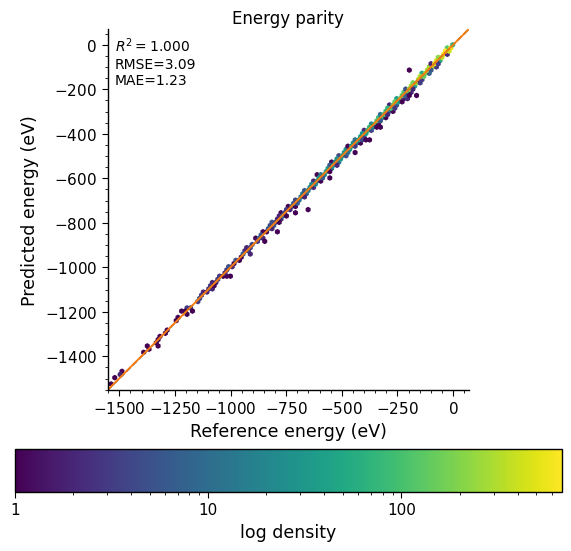

In [56]:
fig, ax = plot_energy_parity(REF_energy, MACE_energy,
    units="eV",
    gridsize=100,
    pct_limits=(.1, 99.9),   
    annotate="short",
)

In [27]:
MACE_forces = np.concatenate([np.asarray(a.arrays["MACE_forces"]).reshape(-1,3) for a in MACE_traj_data])
REF_forces = np.concatenate([np.asarray(a.arrays["REF_forces"]).reshape(-1,3) for a in MACE_traj_data])

In [40]:
def plot_forces_parity(
    REF, MACE, *,
    units="eV/Å",
    gridsize=50,
    cmap="viridis",
    pct_limits=(1, 99),
    annotate="short",
    figsize=(12.0, 5.4),
    lw_guide=1.2, lw_fit=1.4
):
    REF = np.asarray(REF)
    MACE = np.asarray(MACE)
    if REF.shape[-1] != 3 or MACE.shape[-1] != 3:
        raise ValueError("REF and MACE must have last dimension = 3 for (Fx, Fy, Fz).")

    REF = REF.reshape(-1, 3)
    MACE = MACE.reshape(-1, 3)

    def stats(x, y):
        m, c = np.polyfit(x, y, 1)
        yhat = m * x + c
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        rmse = np.sqrt(np.mean((y - yhat) ** 2))
        mae  = np.mean(np.abs(y - x))
        return m, c, r2, rmse, mae

    def shared_symmetric_limits(arrs, pct=(1, 99)):
        # arrs: iterable of 1D arrays (can be nested iterables)
        flat = []
        for a in arrs:
            a = np.asarray(a).ravel()
            if a.size:
                flat.append(a[np.isfinite(a)])
        if not flat:
            return (-1, 1)
        vals = np.concatenate(flat)
        ql, qh = np.percentile(vals, pct)
        L = max(abs(ql), abs(qh)) * 1.05
        if not np.isfinite(L) or L == 0:
            L = max(1.0, np.nanmax(np.abs(vals)) * 1.05)
        return (-L, L)

    plt.rcParams.update({
        "font.size": 11,
        "axes.labelsize": 12.5,
        "axes.titlesize": 12,
        "axes.linewidth": 1.0,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
    })

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 0.12])

    axs = np.array([fig.add_subplot(gs[0, j]) for j in range(3)])

    axes_lbl = ['x', 'y', 'z']

    # ✅ flattened iterable of arrays (no nested pairs)
    lim = shared_symmetric_limits(
        itertools.chain.from_iterable((REF[:, k], MACE[:, k]) for k in range(3)),
        pct=pct_limits
    )

    mappable = None
    for k, ax in enumerate(axs):
        x = REF[:, k]
        y = MACE[:, k]
        m = np.isfinite(x) & np.isfinite(y)
        x = x[m]; y = y[m]

        hb = ax.hexbin(
            x, y, gridsize=gridsize,
            extent=(*lim, *lim),
            bins='log', cmap=cmap, mincnt=1,
            rasterized=True
        )
        mappable = hb

        ax.plot(lim, lim, '--', color='0.3', lw=lw_guide, zorder=1)
        if x.size >= 2:
            mfit, cfit, r2, rmse, mae = stats(x, y)
            xx = np.linspace(*lim, 2)
            ax.plot(xx, mfit * xx + cfit, color='tab:orange', lw=lw_fit, alpha=0.95)
            if annotate == "short":
                txt = (fr"$R^2={r2:.3f}$" "\n"
                       fr"RMSE={rmse:.3g}" "\n"
                       fr"MAE={mae:.3g}")
            elif annotate == "long":
                txt = (fr"$R^2={r2:.3f}$" "\n"
                       fr"RMSE={rmse:.3g}" "\n"
                       fr"MAE={mae:.3g}" "\n"
                       fr"$m={mfit:.3f}$" "\n"
                       fr"$c={cfit:.3f}$")
            else:
                txt = None
            if txt:
                ax.text(0.02, 0.98, txt, transform=ax.transAxes,
                        ha='left', va='top', fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.85, edgecolor='none', boxstyle='round,pad=0.25'))

        ax.set_xlim(*lim); ax.set_ylim(*lim)
        ax.set_aspect('equal', adjustable='box')
        for s in ("top", "right"):
            ax.spines[s].set_visible(False)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='minor', length=2)
        ax.set_title(f"F{axes_lbl[k]}")
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.set_xlabel(f"Reference component ({units})")
        if k == 0:
            ax.set_ylabel(f"MACE-predicted component ({units})")

    cax = fig.add_subplot(gs[1, :])
    cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cb.set_label("log density")
    cb.formatter = LogFormatter(10, labelOnlyBase=False)
    cb.update_ticks()

    fig.suptitle("Forces parity (components)", y=1.02, fontsize=13)

    return fig, axs


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter, LogFormatter
import itertools

def plot_forces_parity_all(
    REF, MACE, *,
    units="eV/Å",
    gridsize=60,
    cmap="viridis",
    pct_limits=(1, 99),
    annotate="short",
    figsize=(5.6, 5.4),
    lw_guide=1.2,
    lw_fit=1.4,
):
    REF = np.asarray(REF)
    MACE = np.asarray(MACE)
    if REF.shape[-1] != 3 or MACE.shape[-1] != 3:
        raise ValueError("REF and MACE must have last dimension = 3 for (Fx, Fy, Fz).")

    # (N,3) → (3N,)
    REF_flat = REF.reshape(-1, 3).ravel()
    MACE_flat = MACE.reshape(-1, 3).ravel()

    # mask non-finite
    m = np.isfinite(REF_flat) & np.isfinite(MACE_flat)
    x = REF_flat[m]
    y = MACE_flat[m]

    def stats(x, y):
        m, c = np.polyfit(x, y, 1)
        yhat = m * x + c
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        rmse = np.sqrt(np.mean((y - yhat) ** 2))
        mae  = np.mean(np.abs(y - x))
        return m, c, r2, rmse, mae

    def shared_symmetric_limits(arrs, pct=(1, 99)):
        flat = []
        for a in arrs:
            a = np.asarray(a).ravel()
            if a.size:
                flat.append(a[np.isfinite(a)])
        if not flat:
            return (-1, 1)
        vals = np.concatenate(flat)
        ql, qh = np.percentile(vals, pct)
        L = max(abs(ql), abs(qh)) * 1.05
        if not np.isfinite(L) or L == 0:
            L = max(1.0, np.nanmax(np.abs(vals)) * 1.05)
        return (-L, L)

    plt.rcParams.update({
        "font.size": 11,
        "axes.labelsize": 12.5,
        "axes.titlesize": 12,
        "axes.linewidth": 1.0,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
    })

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 0.12])

    ax = fig.add_subplot(gs[0, 0])

    # symmetric limits over x and y together
    lim = shared_symmetric_limits((x, y), pct=pct_limits)

    hb = ax.hexbin(
        x, y,
        gridsize=gridsize,
        extent=(*lim, *lim),
        bins="log",
        cmap=cmap,
        mincnt=1,
        rasterized=True,
    )

    # y = x guide
    ax.plot(lim, lim, "--", color="0.3", lw=lw_guide, zorder=1)

    # fit over ALL components
    if x.size >= 2:
        mfit, cfit, r2, rmse, mae = stats(x, y)
        xx = np.linspace(*lim, 2)
        ax.plot(xx, mfit * xx + cfit, color="tab:orange", lw=lw_fit, alpha=0.95)
        if annotate == "short":
            txt = (fr"$R^2={r2:.3f}$" "\n"
                   fr"RMSE={rmse:.3g}" "\n"
                   fr"MAE={mae:.3g}")
        elif annotate == "long":
            txt = (fr"$R^2={r2:.3f}$" "\n"
                   fr"RMSE={rmse:.3g}" "\n"
                   fr"MAE={mae:.3g}" "\n"
                   fr"$m={mfit:.3f}$" "\n"
                   fr"$c={cfit:.3f}$")
        else:
            txt = None
        if txt:
            ax.text(
                0.02, 0.98, txt, transform=ax.transAxes,
                ha="left", va="top", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.85,
                          edgecolor="none", boxstyle="round,pad=0.25"),
            )

    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.set_aspect("equal", adjustable="box")

    for s in ("top", "right"):
        ax.spines[s].set_visible(False)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which="minor", length=2)

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    ax.set_xlabel(f"Reference force components ({units})")
    ax.set_ylabel(f"MACE-predicted force components ({units})")
    ax.set_title("Forces parity (all components)")

    # colorbar
    cax = fig.add_subplot(gs[1, 0])
    cb = fig.colorbar(hb, cax=cax, orientation="horizontal")
    cb.set_label("log density")
    cb.formatter = LogFormatter(10, labelOnlyBase=False)
    cb.update_ticks()

    fig.suptitle("Forces parity (Fx, Fy, Fz combined)", y=1.02, fontsize=13)

    return fig, ax


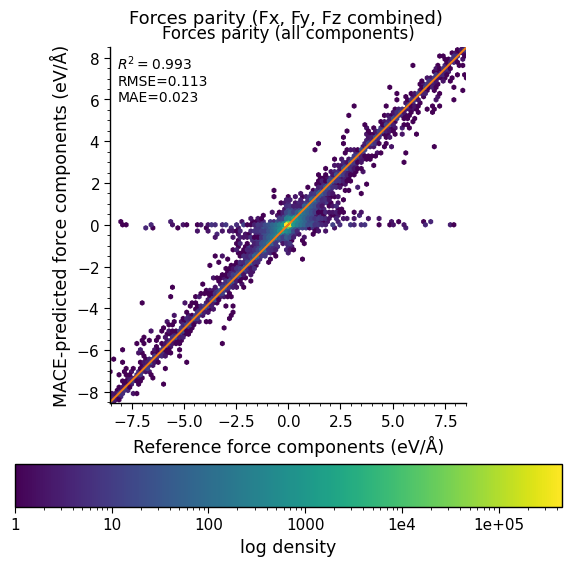

In [44]:
fig, axs = plot_forces_parity_all(REF_forces, MACE_forces,
    units="eV/Å",
    gridsize=100,
    pct_limits=(0.1, 99.9),  
    annotate="short",  
)         

In [26]:
MACE_stress = np.asarray([atom.info["MACE_stress"] for atom in MACE_traj_data]).reshape(-1,3,3)
REF_stress = np.asarray([atom.info["REF_stress"] for atom in MACE_traj_data]).reshape(-1,3,3)

In [43]:
def plot_stress_parity(
    REF, MACE, *,
    units="GPa",
    gridsize=50,
    cmap="viridis",
    pct_limits=(1, 99),          # symmetric percentile limits per group (diag/off)
    annotate="short",            # "none" | "short" (R^2, RMSE, MAE) | "long" (+ m, c)
    figsize=(10.5, 11.2),
    lw_guide=1.2, lw_fit=1.4,
    voigt_order=("xx","yy","zz","yz","xz","xy")  # if inputs are (...,6)
):
    """
    Publication-ready 3x3 stress parity grid using hexbin (log density) with a dedicated
    horizontal colorbar row. Supports inputs as (...,3,3) or (...,6) Voigt.

    Returns
    -------
    fig, axs
    """

    # ---------- helpers ----------
    def _to_33(A):
        A = np.asarray(A)
        if A.ndim >= 2 and A.shape[-2:] == (3, 3):
            return A
        if A.ndim >= 1 and A.shape[-1] == 6:
            # Voigt (assumed symmetric tensor). Map into (3,3)
            names = [s.lower() for s in voigt_order]
            name_to_ij = {"xx": (0,0), "yy": (1,1), "zz": (2,2),
                          "yz": (1,2), "xz": (0,2), "xy": (0,1)}
            out = np.zeros(A.shape[:-1] + (3,3), dtype=A.dtype)
            for k, nm in enumerate(names):
                if nm not in name_to_ij:
                    raise ValueError(f"Unknown Voigt label '{nm}' in voigt_order.")
                i, j = name_to_ij[nm]
                out[..., i, j] = A[..., k]
                out[..., j, i] = A[..., k]
            return out
        raise ValueError("Stress must be shaped (...,3,3) or (...,6) in Voigt form.")

    def group_limits(pairs):
        xs = np.concatenate([REF33[:, i, j] for i, j in pairs])
        ys = np.concatenate([MACE33[:, i, j] for i, j in pairs])
        m = np.isfinite(xs) & np.isfinite(ys)
        if not np.any(m):
            return (-1, 1)
        vals = np.r_[xs[m], ys[m]]
        ql, qh = np.percentile(vals, pct_limits)
        L = max(abs(ql), abs(qh)) * 1.05
        if not np.isfinite(L) or L == 0:
            L = max(1.0, np.nanmax(np.abs(vals)) * 1.05)
        return (-L, L)

    def stats(x, y):
        m, c = np.polyfit(x, y, 1)
        yhat = m * x + c
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        rmse = np.sqrt(np.mean((y - yhat) ** 2))
        mae  = np.mean(np.abs(y - x))
        return m, c, r2, rmse, mae

    # Convert to (...,3,3) and flatten leading dims
    REF33  = _to_33(REF).reshape(-1, 3, 3)
    MACE33 = _to_33(MACE).reshape(-1, 3, 3)

    # ---------- style ----------
    plt.rcParams.update({
        "font.size": 11,
        "axes.labelsize": 12.5,
        "axes.titlesize": 12,
        "axes.linewidth": 1.0,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
    })

    # Figure with a dedicated colorbar row
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(4, 3, figure=fig, height_ratios=[1, 1, 1, 0.08])

    axs = np.empty((3, 3), dtype=object)
    for i, j in itertools.product(range(3), repeat=2):
        axs[i, j] = fig.add_subplot(gs[i, j])

    axes_lbl = ['x', 'y', 'z']
    diag_pairs = [(k, k) for k in range(3)]
    off_pairs  = [(i, j) for i in range(3) for j in range(3) if i != j]
    lim_diag = group_limits(diag_pairs)
    lim_off  = group_limits(off_pairs)

    mappable = None
    for i, j in itertools.product(range(3), repeat=2):
        ax = axs[i, j]
        x = REF33[:, i, j]
        y = MACE33[:, i, j]
        m = np.isfinite(x) & np.isfinite(y)
        x = x[m]; y = y[m]
        xylim = lim_diag if i == j else lim_off

        hb = ax.hexbin(
            x, y, gridsize=gridsize,
            extent=(*xylim, *xylim),
            bins='log', cmap=cmap, mincnt=1,
            rasterized=True
        )
        mappable = hb

        # y = x guide and best-fit
        ax.plot(xylim, xylim, '--', color='0.3', lw=lw_guide, zorder=1)
        if x.size >= 2:
            mfit, cfit, r2, rmse, mae = stats(x, y)
            xx = np.linspace(*xylim, 2)
            ax.plot(xx, mfit * xx + cfit, color='tab:orange', lw=lw_fit, alpha=0.95)
            if annotate == "short":
                txt = (fr"$R^2={r2:.3f}$" "\n"
                       fr"RMSE={rmse:.3g}" "\n"
                       fr"MAE={mae:.3g}")
            elif annotate == "long":
                txt = (fr"$R^2={r2:.3f}$" "\n"
                       fr"RMSE={rmse:.3g}" "\n"
                       fr"MAE={mae:.3g}" "\n"
                       fr"$m={mfit:.3f}$" "\n"
                       fr"$c={cfit:.3f}$")
            else:
                txt = None
            if txt:
                ax.text(0.02, 0.98, txt, transform=ax.transAxes,
                        ha='left', va='top', fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.85, edgecolor='none', boxstyle='round,pad=0.25'))

        # cosmetics
        ax.set_xlim(*xylim); ax.set_ylim(*xylim)
        ax.set_aspect('equal', adjustable='box')
        for s in ("top", "right"):
            ax.spines[s].set_visible(False)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='minor', length=2)
        ax.set_title(f"{axes_lbl[i]}{axes_lbl[j]}")

        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    # Global labels
    u = f" ({units})" if units else ""
    fig.supylabel(f"MACE-predicted stress component{u}", fontsize=13)
    fig.supxlabel(f"Reference stress component{u}", fontsize=13)

    # Dedicated colorbar axis spanning the bottom row
    cax = fig.add_subplot(gs[3, :])
    cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cb.set_label("log density")
    cb.formatter = LogFormatter(10, labelOnlyBase=False)
    cb.update_ticks()

    return fig, axs

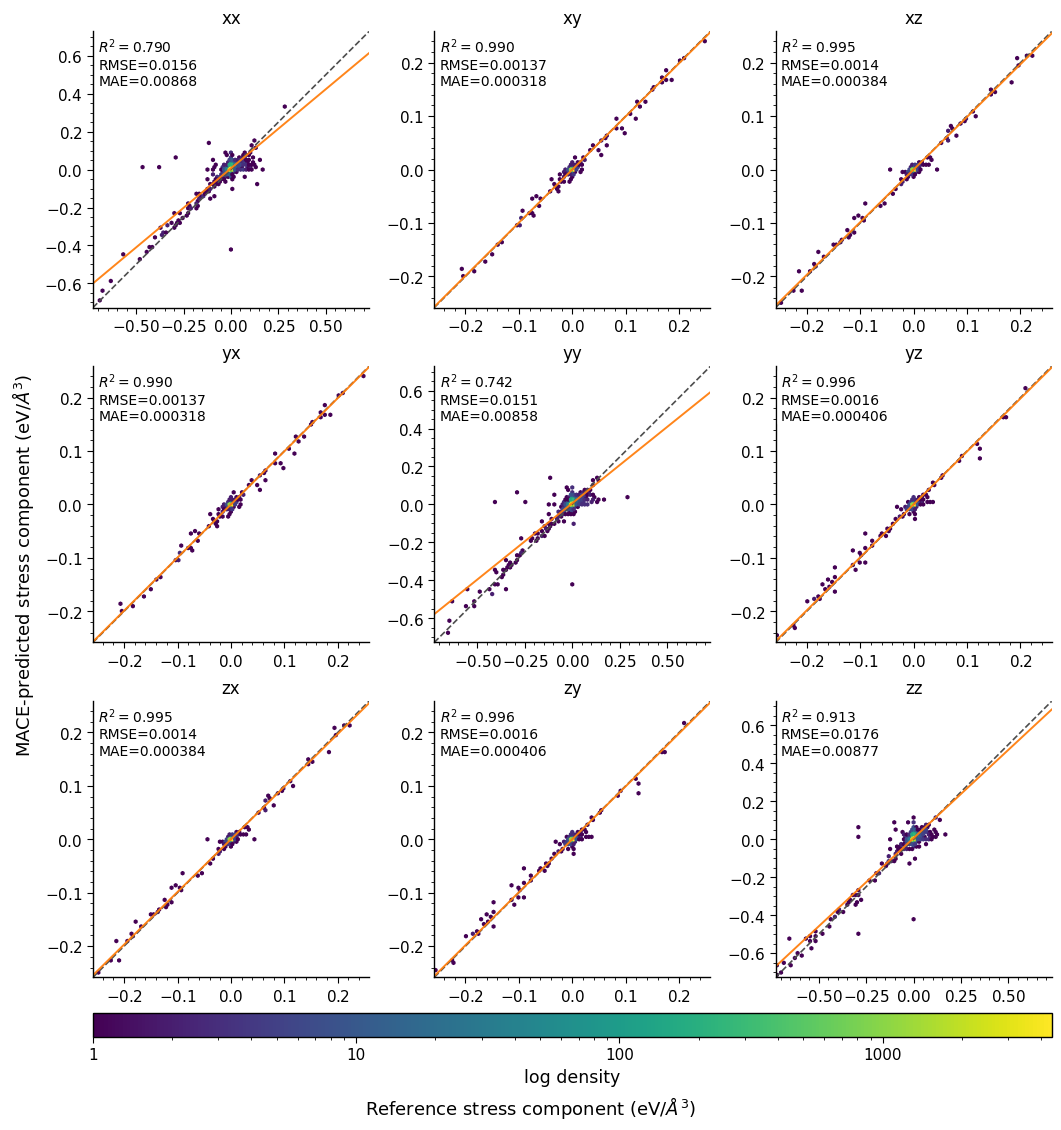

In [44]:
fig, axs = plot_stress_parity(REF_stress, MACE_stress,
    units=r"eV/$\AA^3$",
    gridsize=100,
    pct_limits=(0.1, 99.9),         
    annotate="short",      
)

In [3]:
def fold_polarisation(
    pred_polarisation: torch.Tensor,   # [B,3] intensive P_pred
    ref_polarisation: torch.Tensor,    # [B,3] intensive P_ref  (branch anchor)
    cell: torch.Tensor,         # [B,3,3] ASE-style cell (rows = lattice vectors)
) -> torch.Tensor:
    """
    Return the nearest-image *difference* ΔP_folded to add to P_ref:
        P_pred_fold = P_ref + ΔP_folded
    with ΔP identified modulo the polarization lattice Qpol = cell / |Ω|.
    Keeps autograd intact (no detach), piecewise linear almost everywhere.
    """
    # --- build polarization lattice Q = cell / |Ω| ---
    B = cell.view(-1, 3, 3)
    vol = torch.linalg.det(B).abs().clamp_min(1e-30).view(-1, 1, 1)   # |Ω|
    Q = B / vol                                                      # [B,3,3]
   
    # raw difference
    dP = (pred_polarisation.view(-1, 3) - ref_polarisation.view(-1, 3))   # [B,3]

    # map to fractional coords c solving  Q^T c^T = dP^T   (i.e., c = dP @ Q^{-1})
    c = torch.linalg.solve(Q.transpose(-2, -1), dP.unsqueeze(-1)).squeeze(-1)  # [B,3]

    # wrap into (-0.5, 0.5] with minimum-image convention
    # c_wrap = c - round(c) gives (-0.5, 0.5]; works with autograd (grad ~ 1 a.e.)
    c = c - torch.round(c)

    # back to Cartesian
    dP_folded = torch.einsum("bi,bij->bj", c, Q)                           # [B,3]
    return dP_folded

In [4]:
MACE_polarisation_train = torch.tensor([atom.info["MACE_polarisation"] for atom in MACE_ferroelectric_train_data])
REF_polarisation_train = torch.tensor([atom.info["REF_polarisation"] for atom in MACE_ferroelectric_train_data])
cell_train = torch.tensor([atom.get_cell() for atom in MACE_ferroelectric_train_data])
MACE_polarisation_train = fold_polarisation(MACE_polarisation_train, REF_polarisation_train, cell_train) + REF_polarisation_train

MACE_polarisation_valid = torch.tensor([atom.info["MACE_polarisation"] for atom in MACE_ferroelectric_valid_data])
REF_polarisation_valid = torch.tensor([atom.info["REF_polarisation"] for atom in MACE_ferroelectric_valid_data])
cell_valid = torch.tensor([atom.get_cell() for atom in MACE_ferroelectric_valid_data])
MACE_polarisation_valid = fold_polarisation(MACE_polarisation_valid, REF_polarisation_valid, cell_valid) + REF_polarisation_valid

MACE_polarisation_test = torch.tensor([atom.info["MACE_polarisation"] for atom in MACE_ferroelectric_test_data])
REF_polarisation_test = torch.tensor([atom.info["REF_polarisation"] for atom in MACE_ferroelectric_test_data])
cell_test = torch.tensor([atom.get_cell() for atom in MACE_ferroelectric_test_data])
MACE_polarisation_test = fold_polarisation(MACE_polarisation_test, REF_polarisation_test, cell_test) + REF_polarisation_test

MACE_polarisation = torch.tensor([atom.info["MACE_polarisation"] for atom in MACE_ferroelectric_train_data + MACE_ferroelectric_valid_data + MACE_ferroelectric_test_data])
REF_polarisation = torch.tensor([atom.info["REF_polarisation"] for atom in MACE_ferroelectric_train_data + MACE_ferroelectric_valid_data + MACE_ferroelectric_test_data])
cell = torch.tensor([atom.get_cell() for atom in MACE_ferroelectric_train_data + MACE_ferroelectric_valid_data + MACE_ferroelectric_test_data])
MACE_polarisation = fold_polarisation(MACE_polarisation, REF_polarisation, cell) + REF_polarisation

/tmp/ipykernel_2819923/4189497436.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  MACE_polarisation_train = torch.tensor([atom.info["MACE_polarisation"] for atom in MACE_ferroelectric_train_data])


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, LogFormatter, ScalarFormatter

def plot_polarisation_parity(
    REF_pol, PRED_pol, * ,
    units="μC/cm²",
    which="all",           # "all" = all path points; "end" = last step per material
    gridsize=55,
    cmap="viridis",
    pct_limits=(1, 99),    # robust symmetric limits (global across components)
    annotate="short",      # "none" | "short" (R², RMSE, MAE) | "long" (+ m,c)
    figsize=(4.8, 4.8),
    lw_guide=1.1, lw_fit=1.3
):
    # ----- shape handling -----
    REF_pol  = np.asarray(REF_pol)
    PRED_pol = np.asarray(PRED_pol)
    assert REF_pol.shape == PRED_pol.shape

    if REF_pol.ndim == 3:            # (Nmat, Nsteps, 3)
        X = REF_pol[:, -1, :] if which == "end" else REF_pol.reshape(-1, 3)
        Y = PRED_pol[:, -1, :] if which == "end" else PRED_pol.reshape(-1, 3)
    elif REF_pol.ndim == 2 and REF_pol.shape[1] == 3:
        X, Y = REF_pol, PRED_pol     # (N, 3)
    else:
        raise ValueError("Expected arrays shaped (N,3) or (Nmat,Nsteps,3).")

    def clean(a, b):
        m = np.isfinite(a) & np.isfinite(b)
        return a[m], b[m]

    # ----- global symmetric limits across all components -----
    v = np.r_[X.ravel(), Y.ravel()]
    v = v[np.isfinite(v)]
    if v.size == 0:
        raise ValueError("No finite values found in REF_pol / PRED_pol.")
    ql, qh = np.percentile(v, pct_limits)
    L = max(abs(ql), abs(qh))
    L = 1.05 * L if L > 0 else 1.0
    lim = (-L, L)

    def fit_stats(x, y):
        m, c = np.polyfit(x, y, 1)
        yhat = m * x + c
        resid = y - yhat
        rmse = float(np.sqrt(np.mean(resid**2)))
        mae  = float(np.mean(np.abs(y - x)))
        ss_res = float(np.sum(resid**2))
        ss_tot = float(np.sum((y - np.mean(y))**2))
        r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
        return m, c, r2, rmse, mae

    # ----- flatten all components and clean -----
    x_all, y_all = clean(X.ravel(), Y.ravel())

    # ----- single parity plot -----
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plt.subplots_adjust(left=0.10, right=0.90, bottom=0.10, top=0.93)

    hb = ax.hexbin(
        x_all, y_all,
        gridsize=gridsize,
        extent=(*lim, *lim),
        bins="log",
        cmap=cmap,
        mincnt=1,
        rasterized=True,
    )

    # ideal line
    ax.plot(lim, lim, "--", color="0.35", lw=lw_guide, zorder=1)

    # best-fit line + stats (across all components)
    if x_all.size >= 2:
        mfit, cfit, r2, rmse, mae = fit_stats(x_all, y_all)
        xx = np.linspace(*lim, 200)
        ax.plot(xx, mfit * xx + cfit, color="tab:orange", lw=lw_fit, alpha=0.95)

        if annotate and annotate.lower() != "none":
            if annotate == "short":
                txt = (fr"$R^2={r2:.3f}$" "\n"
                       fr"RMSE={rmse:.3g}" "\n"
                       fr"MAE={mae:.3g}")
            else:
                txt = (fr"$R^2={r2:.3f}$" "\n"
                       fr"RMSE={rmse:.3g}" "\n"
                       fr"MAE={mae:.3g}" "\n"
                       fr"$m={mfit:.3f}$" "\n"
                       f"$c={cfit:.3f}$")
            ax.text(
                0.02, 0.98, txt,
                transform=ax.transAxes,
                ha="left", va="top", fontsize=10,
                bbox=dict(
                    facecolor="white",
                    alpha=0.85,
                    edgecolor="none",
                    boxstyle="round,pad=0.25",
                ),
            )

    # cosmetics
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.set_aspect("equal", adjustable="box")
    for s in ("top", "right"):
        ax.spines[s].set_visible(False)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which="minor", length=2)

    u = f" ({units})" if units else ""
    ax.set_xlabel(f"REF polarisation{u}", fontsize=12.5)
    ax.set_ylabel(f"MACE polarisation{u}", fontsize=12.5)
    ax.set_title("Polarisation parity (x, y, z combined)", pad=4)

    # slim vertical colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.70])  # [left, bottom, width, height]
    cb = fig.colorbar(hb, cax=cax, orientation="vertical")
    cb.set_label("log density", fontsize=10)
    cb.formatter = LogFormatter(10, labelOnlyBase=False)
    cb.update_ticks()

    # tidy tick formatting
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    return fig, ax


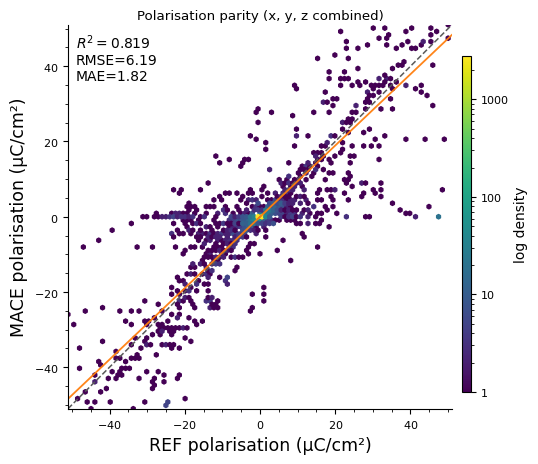

In [7]:
fig, axs = plot_polarisation_parity(REF_polarisation * 1602, MACE_polarisation * 1602,
    units="μC/cm²",
    gridsize=100,
    pct_limits=(1, 99),    # robust symmetric limits (global across components)
    annotate="short",      # "none" | "short" (R², RMSE, MAE) | "long" (+ m,c)
)

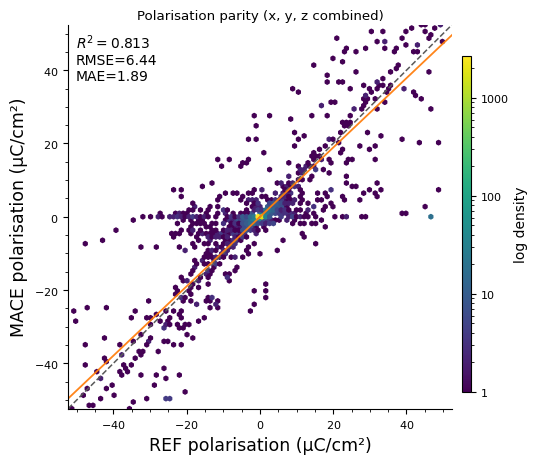

In [11]:
fig, axs = plot_polarisation_parity(REF_polarisation_train * 1602, MACE_polarisation_train * 1602,
    units="μC/cm²",
    gridsize=100,
    pct_limits=(1, 99),    # robust symmetric limits (global across components)
    annotate="short",      # "none" | "short" (R², RMSE, MAE) | "long" (+ m,c)
)
fig.savefig("plots/polarisation-2panel-parity-mh-train.pdf", dpi=300, bbox_inches="tight")

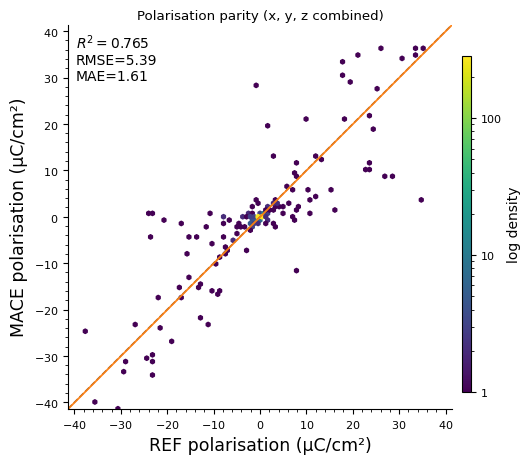

In [12]:
fig, axs = plot_polarisation_parity(REF_polarisation_valid * 1602, MACE_polarisation_valid * 1602,
    units="μC/cm²",
    gridsize=100,
    pct_limits=(1, 99),    # robust symmetric limits (global across components)
    annotate="short",      # "none" | "short" (R², RMSE, MAE) | "long" (+ m,c)
)
fig.savefig("plots/polarisation-2panel-parity-mh-valid.pdf", dpi=300, bbox_inches="tight")

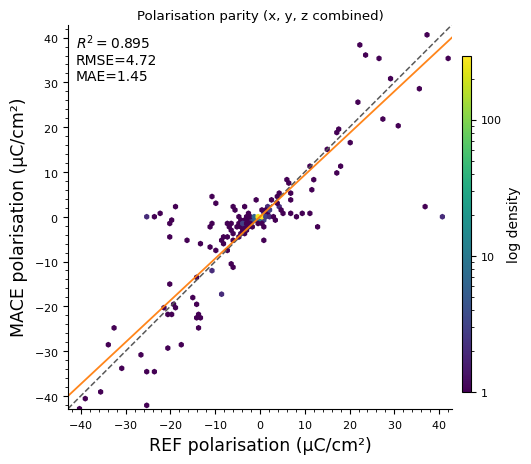

In [13]:
fig, axs = plot_polarisation_parity(REF_polarisation_test * 1602, MACE_polarisation_test * 1602,
    units="μC/cm²",
    gridsize=100,
    pct_limits=(1, 99),    # robust symmetric limits (global across components)
    annotate="short",      # "none" | "short" (R², RMSE, MAE) | "long" (+ m,c)
)
fig.savefig("plots/polarisation-2panel-parity-mh-test.pdf", dpi=300, bbox_inches="tight")

In [3]:
MACE_becs_train = np.concatenate([np.asarray(a.arrays["MACE_becs"]).reshape(-1,3,3) for a in MACE_dielectric_train_data])
REF_becs_train = np.concatenate([np.asarray(a.arrays["REF_becs"]).reshape(-1,3,3) for a in MACE_dielectric_train_data])

MACE_becs_valid = np.concatenate([np.asarray(a.arrays["MACE_becs"]).reshape(-1,3,3) for a in MACE_dielectric_valid_data])
REF_becs_valid = np.concatenate([np.asarray(a.arrays["REF_becs"]).reshape(-1,3,3) for a in MACE_dielectric_valid_data])

MACE_becs_test = np.concatenate([np.asarray(a.arrays["MACE_becs"]).reshape(-1,3,3) for a in MACE_dielectric_test_data])
REF_becs_test = np.concatenate([np.asarray(a.arrays["REF_becs"]).reshape(-1,3,3) for a in MACE_dielectric_test_data])

MACE_becs = np.concatenate([np.asarray(a.arrays["MACE_becs"]).reshape(-1,3,3) for a in MACE_dielectric_train_data+MACE_dielectric_valid_data+MACE_dielectric_test_data])
REF_becs = np.concatenate([np.asarray(a.arrays["REF_becs"]).reshape(-1,3,3) for a in MACE_dielectric_train_data+MACE_dielectric_valid_data+MACE_dielectric_test_data])

In [7]:
def plot_becs_parity(
    REF, MACE, *,
    units="e",
    gridsize=50,                # hex resolution (increase for smoother look)
    cmap="viridis",
    pct_limits=(1, 99),         # symmetric percentile limits per group
    annotate="short",           # "none" | "short" (R^2, RMSE) | "long" (+ m,c)
    figsize=(10.5, 11.2),       # a touch taller to make room for bottom colorbar
    lw_guide=1.2, lw_fit=1.4
):
    """
    Publication-ready 3x3 parity grid using hexbin (log density) with a dedicated
    horizontal colorbar row (no overlap/clipping).

    Returns
    -------
    fig, axs
    """
    REF = np.asarray(REF)
    MACE = np.asarray(MACE)

    # ---------- helpers ----------
    def group_limits(pairs):
        xs = np.concatenate([REF[:, i, j] for i, j in pairs])
        ys = np.concatenate([MACE[:, i, j] for i, j in pairs])
        m = np.isfinite(xs) & np.isfinite(ys)
        vals = np.r_[xs[m], ys[m]]
        ql, qh = np.percentile(vals, pct_limits)
        L = max(abs(ql), abs(qh)) * 1.05
        return (-L, L)

    def stats(x, y):
        m, c = np.polyfit(x, y, 1)
        yhat = m * x + c
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        rmse = np.sqrt(np.mean((y - yhat) ** 2))
        mae  = np.mean(np.abs(y - x))
        return m, c, r2, rmse, mae

    # ---------- style ----------
    plt.rcParams.update({
        "font.size": 11,
        "axes.labelsize": 12.5,
        "axes.titlesize": 12,
        "axes.linewidth": 1.0,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
    })

    # Figure with a dedicated colorbar row
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(4, 3, figure=fig, height_ratios=[1, 1, 1, 0.08])  # last row for colorbar

    axs = np.empty((3, 3), dtype=object)
    for i, j in itertools.product(range(3), repeat=2):
        axs[i, j] = fig.add_subplot(gs[i, j])

    axes_lbl = ['x', 'y', 'z']
    diag_pairs = [(k, k) for k in range(3)]
    off_pairs  = [(i, j) for i in range(3) for j in range(3) if i != j]
    lim_diag = group_limits(diag_pairs)
    lim_off  = group_limits(off_pairs)

    mappable = None
    for i, j in itertools.product(range(3), repeat=2):
        ax = axs[i, j]
        x = REF[:, i, j]
        y = MACE[:, i, j]
        m = np.isfinite(x) & np.isfinite(y)
        x = x[m]; y = y[m]
        xylim = lim_diag if i == j else lim_off

        # hexbin (log density) — no overlap, very readable
        hb = ax.hexbin(
            x, y, gridsize=gridsize,
            extent=(*xylim, *xylim),
            bins='log', cmap=cmap, mincnt=1,  # mincnt avoids -inf
            rasterized=True
        )
        mappable = hb

        # y = x guide and best-fit
        ax.plot(xylim, xylim, '--', color='0.3', lw=lw_guide, zorder=1)
        if x.size >= 2:
            mfit, cfit, r2, rmse, mae = stats(x, y)
            xx = np.linspace(*xylim, 2)
            ax.plot(xx, mfit * xx + cfit, color='tab:orange', lw=lw_fit, alpha=0.95)
            if annotate == "short":
                txt = (fr"$R^2={r2:.3f}$" "\n"
                    fr"RMSE={rmse:.3g}" "\n"
                    fr"MAE={mae:.3g}")
            elif annotate == "long":
                txt = (fr"$R^2={r2:.3f}$" "\n"
                    fr"RMSE={rmse:.3g}" "\n"
                    fr"MAE={mae:.3g}" "\n"
                    fr"$m={mfit:.3f}$" "\n"
                    fr"$c={cfit:.3f}$")
            ax.text(0.02, 0.98, txt, transform=ax.transAxes,
                    ha='left', va='top', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.85, edgecolor='none', boxstyle='round,pad=0.25'))

        # cosmetics
        ax.set_xlim(*xylim); ax.set_ylim(*xylim)
        ax.set_aspect('equal', adjustable='box')
        for s in ("top", "right"):
            ax.spines[s].set_visible(False)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='minor', length=2)
        ax.set_title(f"{axes_lbl[i]}{axes_lbl[j]}", pad=4)

    # Global labels (units if provided)
    u = f" ({units})" if units else ""
    fig.supylabel(f"MACE-predicted BEC component{u}", fontsize=13)
    fig.supxlabel(f"Reference BEC component{u}", fontsize=13)

    # Dedicated colorbar axis spanning the bottom row
    cax = fig.add_subplot(gs[3, :])
    cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cb.set_label("log density")
    cb.formatter = LogFormatter(10, labelOnlyBase=False)
    cb.update_ticks()

    # Tidy number formatting
    for ax in axs.ravel():
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    return fig, axs

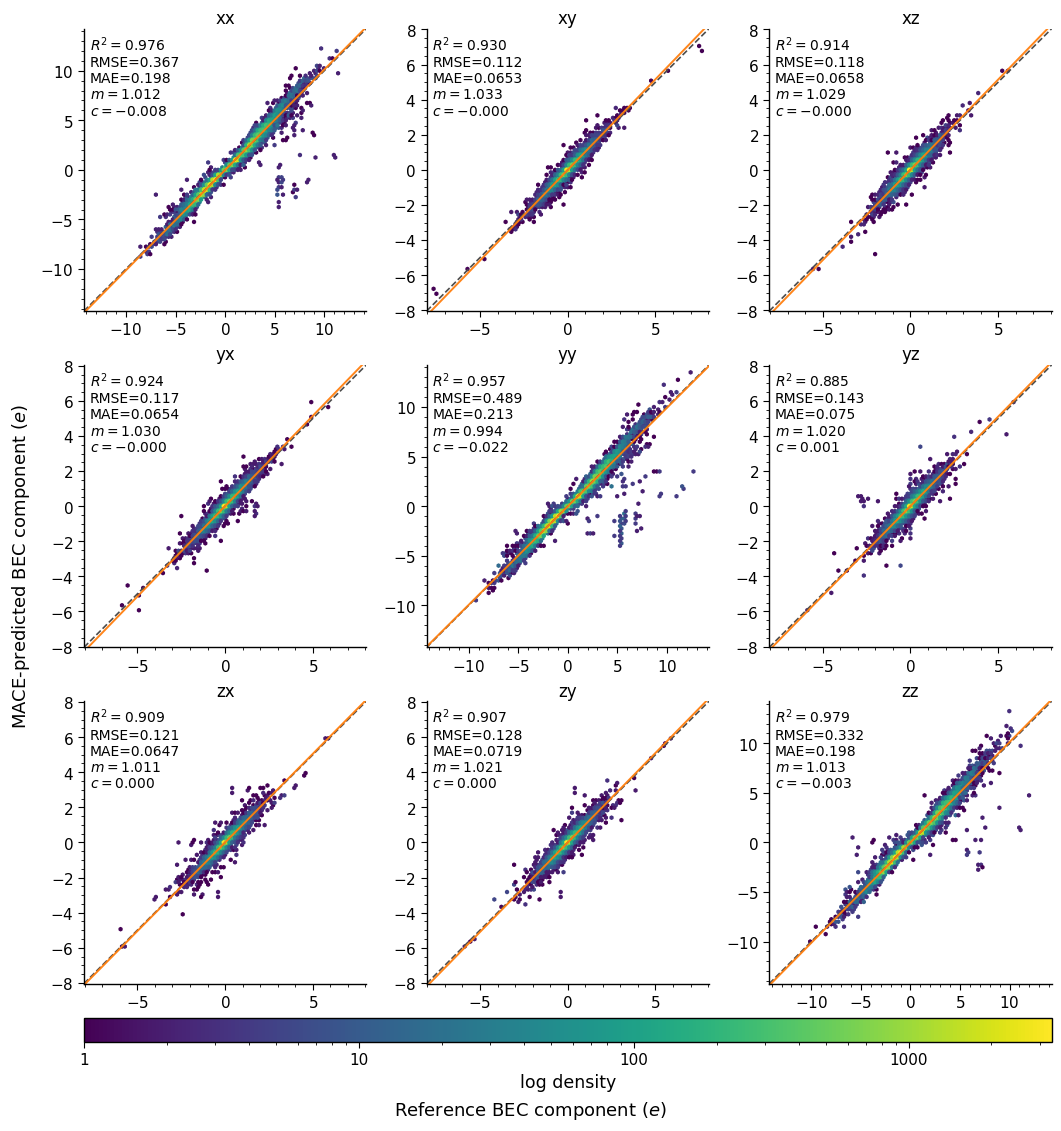

In [37]:
fig, axs = plot_becs_parity(REF_becs_train, MACE_becs_train, units=fr"$e$", pct_limits=(0.0,100), gridsize=100, annotate='long')
fig.savefig("plots/becs_parity_hex_train-mh.pdf", bbox_inches="tight")

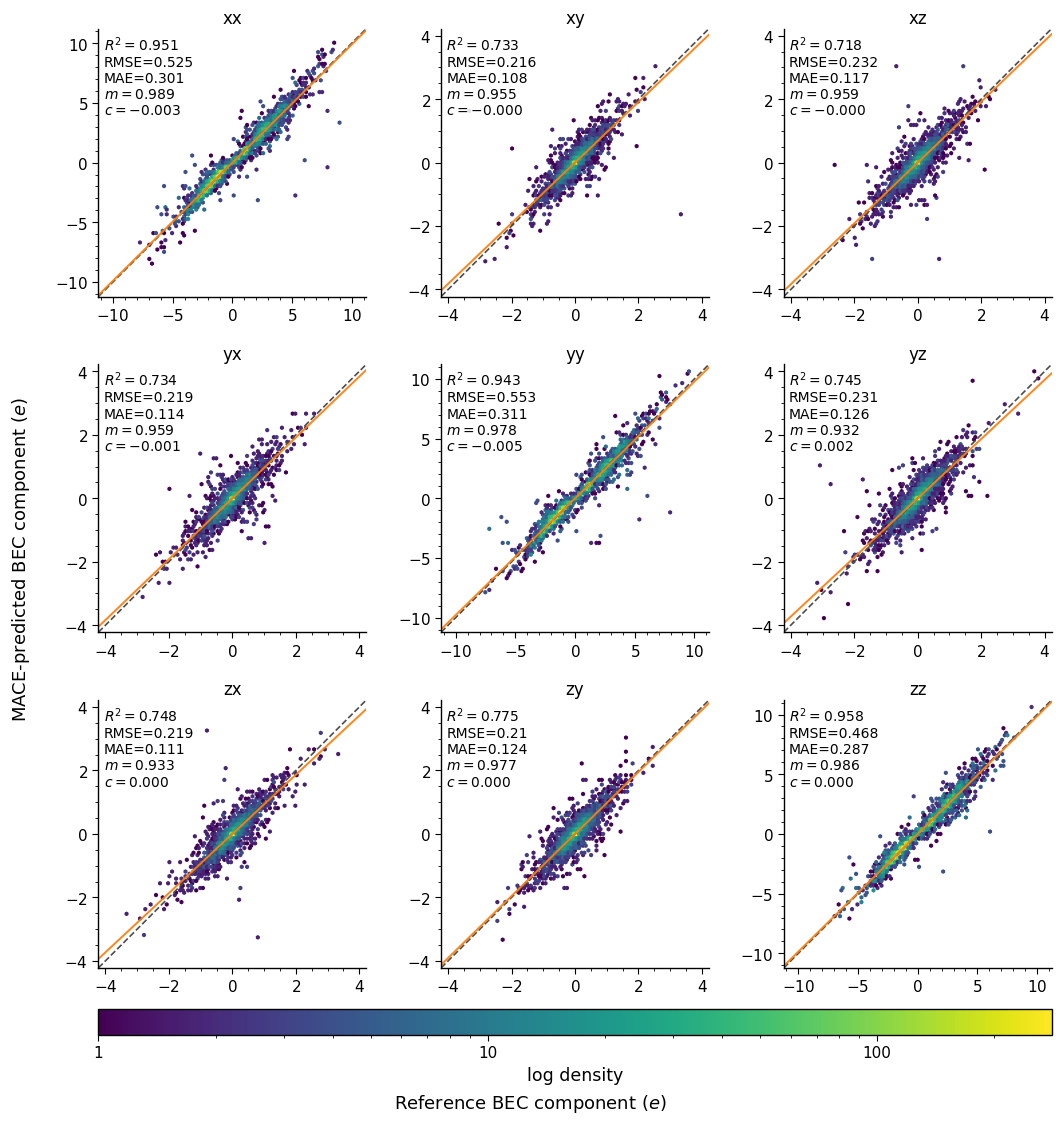

In [38]:
fig, axs = plot_becs_parity(REF_becs_valid, MACE_becs_valid, units=fr"$e$", pct_limits=(0.0,100), gridsize=100, annotate='long')
fig.savefig("plots/becs_parity_hex_valid-mh.pdf", bbox_inches="tight")

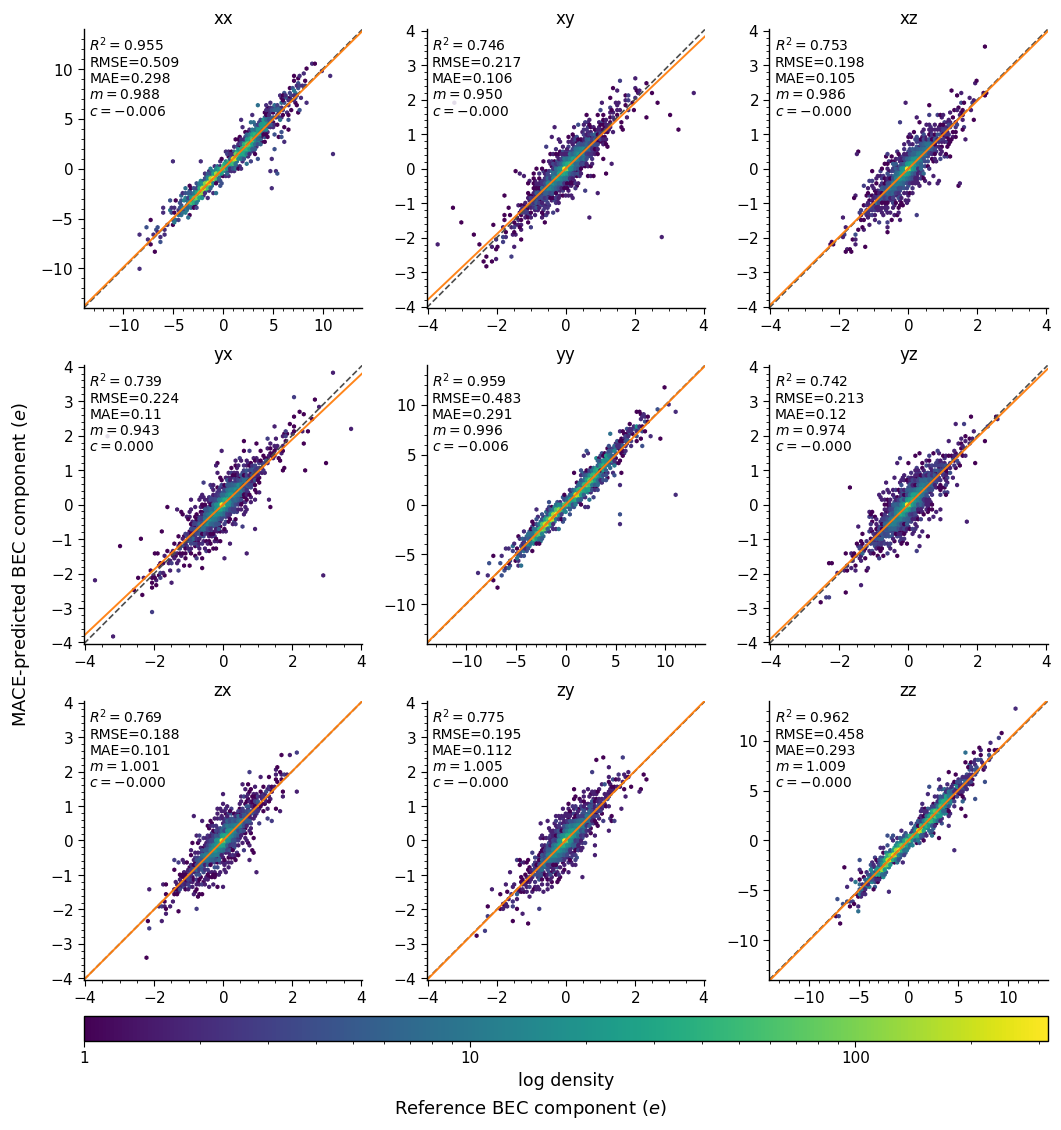

In [5]:
fig, axs = plot_becs_parity(REF_becs_test, MACE_becs_test, units=fr"$e$", pct_limits=(0.0,100), gridsize=100, annotate='long')
fig.savefig("plots/becs_parity_hex_test-mh.pdf", bbox_inches="tight")

In [19]:
MACE_polarisability_train = np.concatenate([np.asarray(a.info["MACE_polarisability"]).reshape(3,3) for a in MACE_dielectric_train_data]).reshape(-1,3,3)
REF_polarisability_train = np.concatenate([np.asarray(a.info["REF_polarisability"]).reshape(3,3) for a in MACE_dielectric_train_data]).reshape(-1,3,3)

MACE_polarisability_valid = np.concatenate([np.asarray(a.info["MACE_polarisability"]).reshape(3,3) for a in MACE_dielectric_valid_data]).reshape(-1,3,3)
REF_polarisability_valid = np.concatenate([np.asarray(a.info["REF_polarisability"]).reshape(3,3) for a in MACE_dielectric_valid_data]).reshape(-1,3,3)

MACE_polarisability_test = np.concatenate([np.asarray(a.info["MACE_polarisability"]).reshape(3,3) for a in MACE_dielectric_test_data]).reshape(-1,3,3)
REF_polarisability_test = np.concatenate([np.asarray(a.info["REF_polarisability"]).reshape(3,3) for a in MACE_dielectric_test_data]).reshape(-1,3,3)

MACE_polarisability = np.concatenate([np.asarray(a.info["MACE_polarisability"]).reshape(3,3) for a in MACE_dielectric_train_data+MACE_dielectric_valid_data+MACE_dielectric_test_data]).reshape(-1,3,3)
REF_polarisability = np.concatenate([np.asarray(a.info["REF_polarisability"]).reshape(3,3) for a in MACE_dielectric_train_data+MACE_dielectric_valid_data+MACE_dielectric_test_data]).reshape(-1,3,3)

In [9]:
def plot_polarisability_parity(
    REF_alpha, PRED_alpha, *,
    units="Å$^3$",          # common for polarisability; change if needed
    gridsize=50,            # hex resolution (increase for smoother look)
    cmap="viridis",
    pct_limits_diag=(1, 99),    # percentiles for diagonal panels (upper bound)
    pct_limits_offd=(1, 99),    # percentiles for off-diagonal panels (symmetric)
    annotate="short",           # "none" | "short" (R^2, RMSE, MAE) | "long" (+ m,c)
    figsize=(10.5, 11.2),       # taller to reserve a bottom row for the colorbar
    lw_guide=1.2, lw_fit=1.4
):
    """
    Publication-ready 3x3 parity grid for polarisability tensors using hexbin (log density).
    Diagonal panels are consvalided to non-negative axes (alpha_xx, alpha_yy, alpha_zz > 0).

    Parameters
    ----------
    REF_alpha, PRED_alpha : array-like, shape (N, 3, 3)
        Reference and predicted polarizabilities.
    units : str
        Axis label units (default Å^3).
    pct_limits_diag : (lo, hi)
        Percentiles to set the *upper* bound for diagonals; lower bound is 0.
    pct_limits_offd : (lo, hi)
        Percentiles to set *symmetric* bounds for off-diagonals about 0.
    annotate : {"none","short","long"}
        Controls per-panel text: short = R²/RMSE/MAE (line-broken); long adds slope/intercept.

    Returns
    -------
    fig, axs : Figure and (3x3) Axes array
    """
    REF_alpha = np.asarray(REF_alpha)
    PRED_alpha = np.asarray(PRED_alpha)
    assert REF_alpha.shape == PRED_alpha.shape and REF_alpha.shape[1:] == (3, 3), \
        "Inputs must be (N,3,3)."

    def _clean(x, y):
        m = np.isfinite(x) & np.isfinite(y)
        return x[m], y[m]

    def _diag_limits():
        # All diagonals concatenated; use percentiles for upper bound, lower bound at 0
        xs = np.concatenate([REF_alpha[:, k, k] for k in range(3)])
        ys = np.concatenate([PRED_alpha[:, k, k] for k in range(3)])
        xs, ys = _clean(xs, ys)
        vals = np.r_[xs, ys]
        ql, qh = np.percentile(vals, pct_limits_diag)
        upper = max(qh, 0.0)
        L = upper * 1.05 if upper > 0 else 1.0
        return (0.0, L)  # non-negative axis

    def _offd_limits():
        # All off-diagonals concatenated; symmetric about 0
        pairs = [(i, j) for i in range(3) for j in range(3) if i != j]
        xs = np.concatenate([REF_alpha[:, i, j] for (i, j) in pairs])
        ys = np.concatenate([PRED_alpha[:, i, j] for (i, j) in pairs])
        xs, ys = _clean(xs, ys)
        vals = np.r_[xs, ys]
        ql, qh = np.percentile(vals, pct_limits_offd)
        L = max(abs(ql), abs(qh)) * 1.05
        if not np.isfinite(L) or L == 0:
            L = 1.0
        return (-L, L)

    def _fit_stats(x, y):
        m, c = np.polyfit(x, y, 1)
        yhat = m * x + c
        resid = y - yhat
        rmse = float(np.sqrt(np.mean(resid**2)))
        mae  = float(np.mean(np.abs(y - x)))
        ss_res = float(np.sum(resid**2))
        ss_tot = float(np.sum((y - np.mean(y))**2))
        r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
        return m, c, r2, rmse, mae

    # ---------- style ----------
    plt.rcParams.update({
        "font.size": 11,
        "axes.labelsize": 12.5,
        "axes.titlesize": 12,
        "axes.linewidth": 1.0,
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
    })

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(4, 3, figure=fig, height_ratios=[1, 1, 1, 0.08])  # last row for colorbar

    axs = np.empty((3, 3), dtype=object)
    for i, j in itertools.product(range(3), repeat=2):
        axs[i, j] = fig.add_subplot(gs[i, j])

    lim_diag = _diag_limits()
    lim_offd = _offd_limits()

    axes_lbl = ['x', 'y', 'z']
    mappable = None

    for i, j in itertools.product(range(3), repeat=2):
        ax = axs[i, j]
        x = REF_alpha[:, i, j]
        y = PRED_alpha[:, i, j]
        x, y = _clean(x, y)

        xylim = lim_diag if i == j else lim_offd

        hb = ax.hexbin(
            x, y, gridsize=gridsize,
            extent=(*xylim, *xylim),
            bins='log', cmap=cmap, mincnt=1,
            rasterized=True
        )
        mappable = hb

        # Ideal and best-fit lines
        ax.plot(xylim, xylim, '--', color='0.3', lw=lw_guide, zorder=1)
        if x.size >= 2:
            mfit, cfit, r2, rmse, mae = _fit_stats(x, y)
            xx = np.linspace(*xylim, 2)
            ax.plot(xx, mfit * xx + cfit, color='tab:orange', lw=lw_fit, alpha=0.95)

            if annotate and annotate.lower() != "none":
                if annotate == "short":
                    txt = (fr"$R^2={r2:.3f}$" "\n"
                           fr"RMSE={rmse:.3g}" "\n"
                           fr"MAE={mae:.3g}")
                else:  # "long"
                    txt = (fr"$R^2={r2:.3f}$" "\n"
                           fr"RMSE={rmse:.3g}" "\n"
                           fr"MAE={mae:.3g}" "\n"
                           fr"$m={mfit:.3f}$" "\n" 
                           fr"$c={cfit:.3f}$")
                ax.text(0.02, 0.98, txt, transform=ax.transAxes,
                        ha='left', va='top', fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.85,
                                  edgecolor='none', boxstyle='round,pad=0.25'))

        # cosmetics
        ax.set_xlim(*xylim); ax.set_ylim(*xylim)
        ax.set_aspect('equal', adjustable='box')
        for s in ("top", "right"):
            ax.spines[s].set_visible(False)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='minor', length=2)
        ax.set_title(f"{axes_lbl[i]}{axes_lbl[j]}", pad=4)

    # Global labels
    u = f" ({units})" if units else ""
    fig.supylabel(f"Predicted polarisability component{u}", fontsize=13)
    fig.supxlabel(f"Reference polarisability component{u}", fontsize=13)

    # Bottom-row colorbar (no overlap)
    cax = fig.add_subplot(gs[3, :])
    cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cb.set_label("log density")
    cb.formatter = LogFormatter(10, labelOnlyBase=False)
    cb.update_ticks()

    # Tidy number formatting
    for ax in axs.ravel():
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    return fig, axs

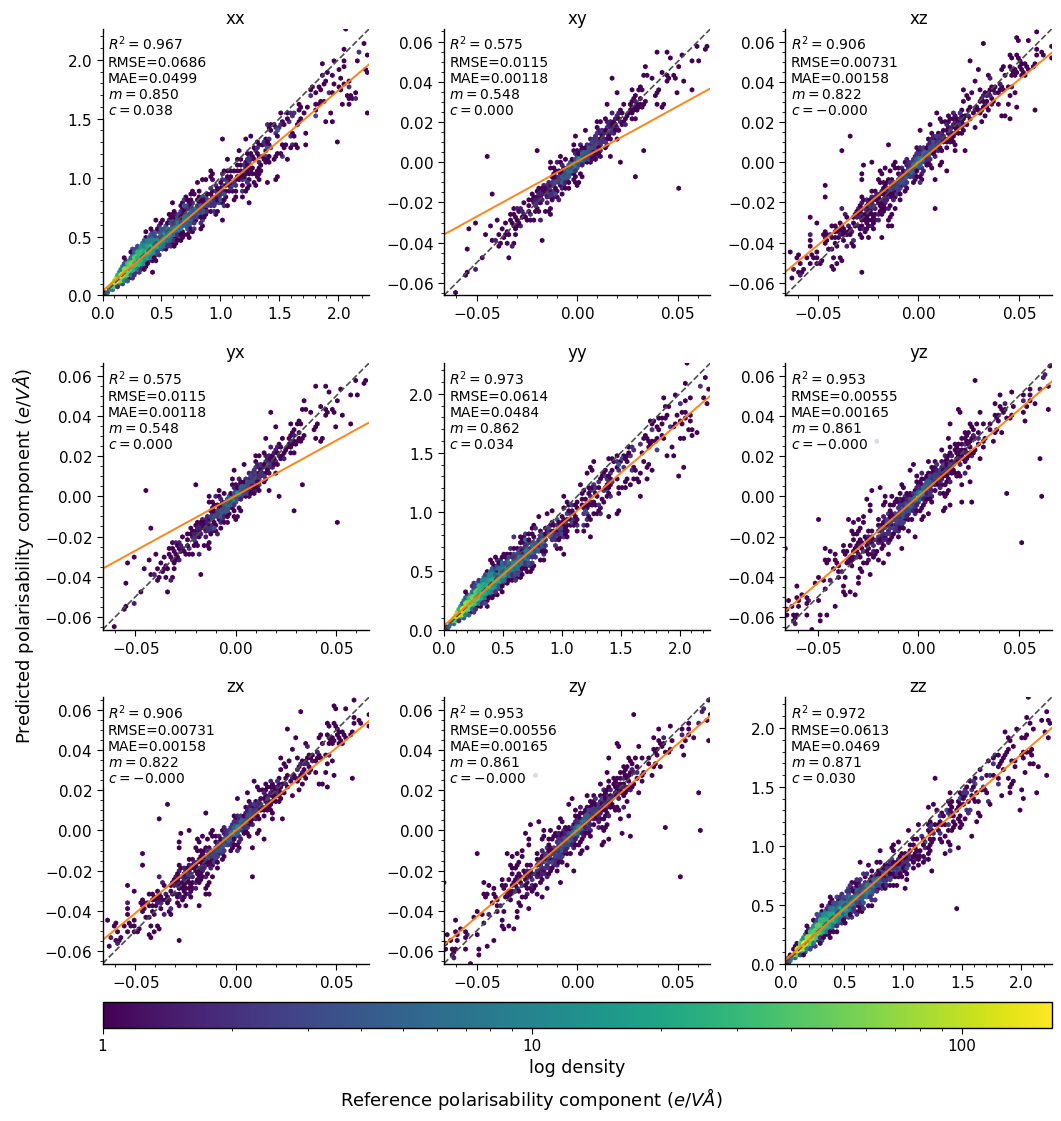

In [10]:
fig, axs = plot_polarisability_parity(REF_polarisability_train, MACE_polarisability_train, units=fr"$e/VÅ$", gridsize=80, annotate='long', pct_limits_diag=(1, 99), pct_limits_offd=(1, 99))
fig.savefig("plots/polarisability_parity_hex_train-mh.pdf", bbox_inches="tight")

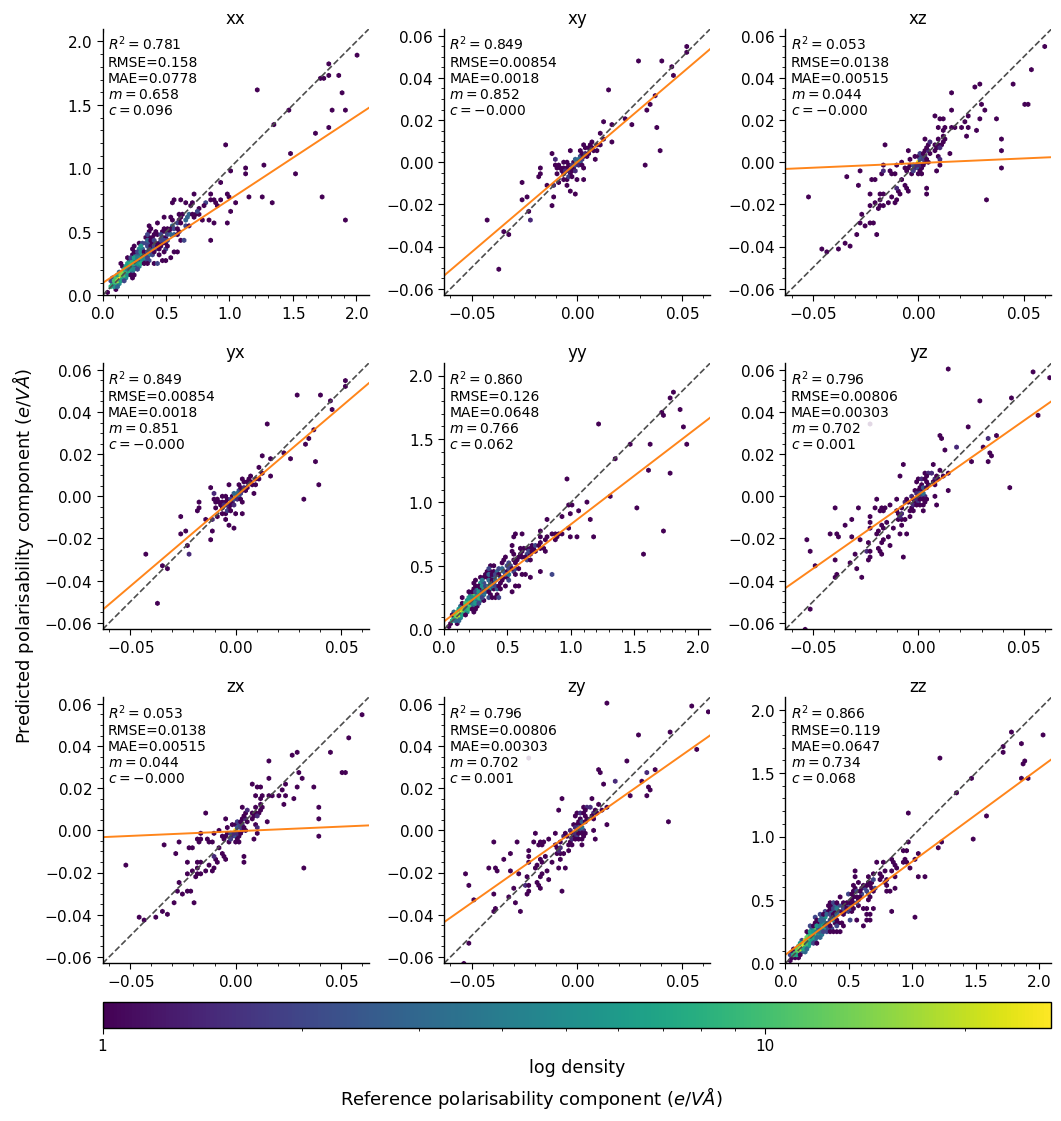

In [11]:
fig, axs = plot_polarisability_parity(REF_polarisability_valid, MACE_polarisability_valid, units=fr"$e/VÅ$", gridsize=80, annotate='long', pct_limits_diag=(1, 99), pct_limits_offd=(1, 99))
fig.savefig("plots/polarisability_parity_hex_valid-mh.pdf", bbox_inches="tight")

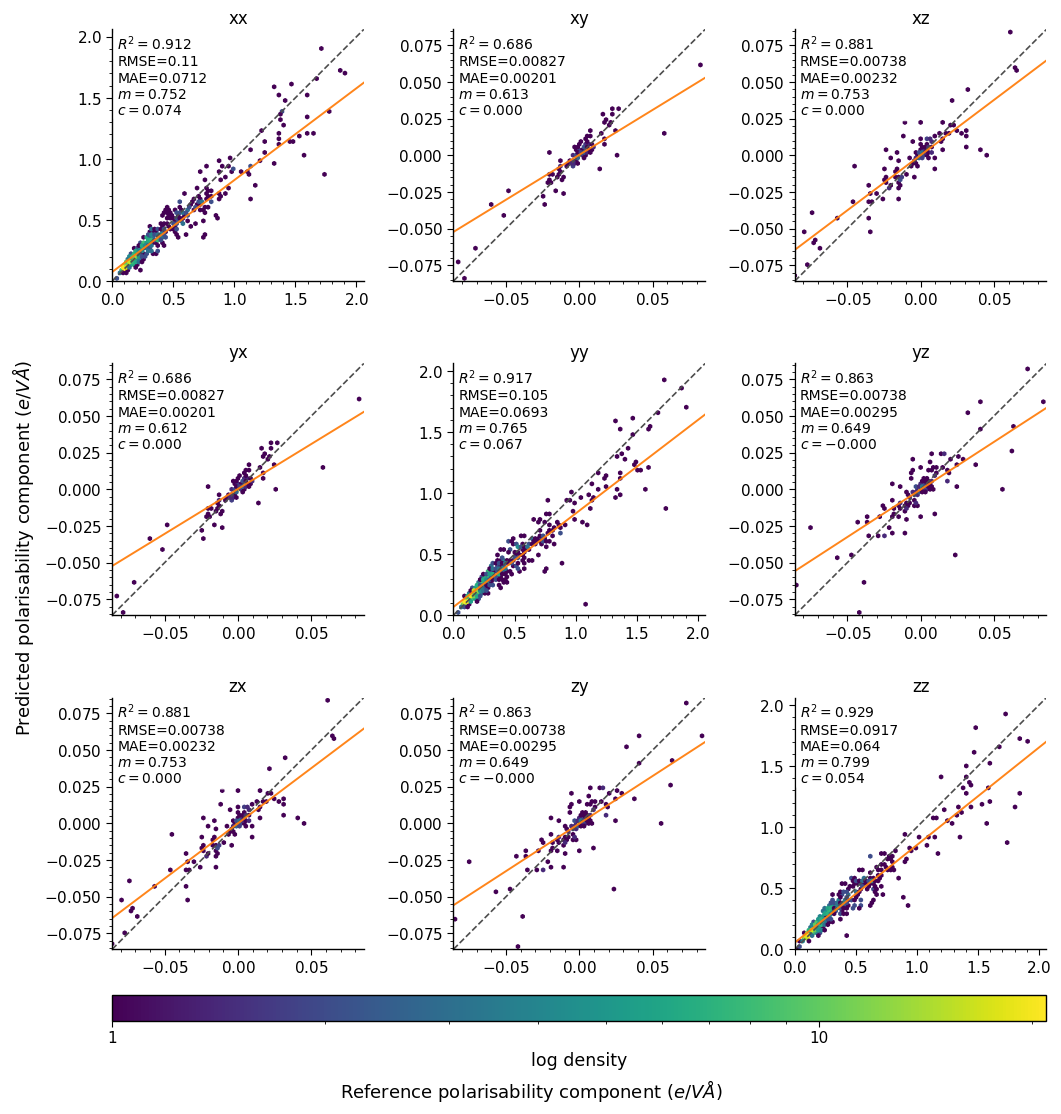

In [12]:
fig, axs = plot_polarisability_parity(REF_polarisability_test, MACE_polarisability_test, units=fr"$e/VÅ$", gridsize=80, annotate='long', pct_limits_diag=(1, 99), pct_limits_offd=(1, 99))
fig.savefig("plots/polarisability_parity_hex_test-mh.pdf", bbox_inches="tight")

In [31]:
def _two_panel_parity_hex(
    REF, PRED, *, units="", diag_nonneg=False,
    pct_limits_diag=(1, 99), pct_limits_offd=(1, 99),
    gridsize=55, cmap="viridis", annotate="short",
    figsize=(9.5, 3.9), lw_guide=1.1, lw_fit=1.3
):
    """
    REF, PRED: arrays of shape (N, 3, 3). Returns (fig, (ax_diag, ax_offd)).
    """
    REF = np.asarray(REF); PRED = np.asarray(PRED)
    assert REF.shape == PRED.shape and REF.shape[1:] == (3, 3)

    # Collect data
    x_diag = np.concatenate([REF[:, k, k] for k in range(3)])
    y_diag = np.concatenate([PRED[:, k, k] for k in range(3)])
    off_pairs = [(i, j) for i in range(3) for j in range(3) if i != j]
    x_offd = np.concatenate([REF[:, i, j] for (i, j) in off_pairs])
    y_offd = np.concatenate([PRED[:, i, j] for (i, j) in off_pairs])

    def clean(x, y):
        m = np.isfinite(x) & np.isfinite(y)
        return x[m], y[m]

    x_diag, y_diag = clean(x_diag, y_diag)
    x_offd, y_offd = clean(x_offd, y_offd)

    # Limits
    def sym_lim(x, y, p=(1, 99), pad=1.05):
        v = np.r_[x, y]
        ql, qh = np.percentile(v, p)
        L = max(abs(ql), abs(qh))
        return (-pad*L if L > 0 else -1.0, pad*L if L > 0 else 1.0)

    def diag_lim(x, y, p=(1, 99), pad=1.05, nonneg=False):
        v = np.r_[x, y]
        ql, qh = np.percentile(v, p)
        if nonneg:
            upper = max(qh, 0.0)
            U = pad*upper if upper > 0 else 1.0
            return (0.0, U)
        else:
            return sym_lim(x, y, p, pad)

    lim_diag = diag_lim(x_diag, y_diag, pct_limits_diag, nonneg=diag_nonneg)
    lim_offd = sym_lim(x_offd, y_offd, pct_limits_offd)

    def fit_stats(x, y):
        m, c = np.polyfit(x, y, 1)
        yhat = m*x + c
        resid = y - yhat
        rmse = float(np.sqrt(np.mean(resid**2)))
        mae  = float(np.mean(np.abs(y - x)))
        ss_res = float(np.sum(resid**2))
        ss_tot = float(np.sum((y - np.mean(y))**2))
        r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
        return m, c, r2, rmse, mae

    # Figure (two columns + slim colorbar on the right)
    fig, (axD, axO) = plt.subplots(1, 2, figsize=figsize, constrained_layout=False)
    plt.subplots_adjust(left=0.08, right=0.88, bottom=0.18, top=0.90, wspace=0.35)

    # Plot helper
    def panel(ax, x, y, lim, title):
        hb = ax.hexbin(x, y, gridsize=gridsize, extent=(*lim, *lim),
                       bins='log', cmap=cmap, mincnt=1, rasterized=True)
        ax.plot(lim, lim, '--', color='0.35', lw=lw_guide, zorder=1)
        if x.size >= 2:
            m, c, r2, rmse, mae = fit_stats(x, y)
            xx = np.linspace(*lim, 2)
            ax.plot(xx, m*xx + c, color='tab:orange', lw=lw_fit, alpha=0.95)
            if annotate and annotate.lower() != "none":
                if annotate == "short":
                    txt = (fr"$R^2={r2:.3f}$" "\n"
                           fr"RMSE={rmse:.3g}" "\n"
                           fr"MAE={mae:.3g}")
                else:  # "long"
                    txt = (fr"$R^2={r2:.3f}$" "\n"
                           fr"RMSE={rmse:.3g}" "\n"
                           fr"MAE={mae:.3g}" "\n"
                           fr"$m={m:.3f},\ c={c:.3f}$")
                ax.text(0.02, 0.98, txt, transform=ax.transAxes,
                        ha='left', va='top', fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.85, edgecolor='none',
                                  boxstyle='round,pad=0.25'))
        ax.set_title(title, pad=3)
        ax.set_xlim(*lim); ax.set_ylim(*lim)
        ax.set_aspect('equal', adjustable='box')
        for s in ("top", "right"): ax.spines[s].set_visible(False)
        ax.xaxis.set_minor_locator(AutoMinorLocator()); ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='minor', length=2)
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        return hb

    mappable = panel(axD, x_diag, y_diag, lim_diag, "diagonals (xx, yy, zz)")
    panel(axO, x_offd, y_offd, lim_offd, "off-diagonals (xy, xz, yx, yz, zx, zy)")

    # Shared labels + slim vertical colorbar
    u = f" ({units})" if units else ""
    fig.supxlabel(f"REF stress{u}", fontsize=12.5)
    fig.supylabel(f"MACE stress{u}", fontsize=12.5)

    cax = fig.add_axes([0.90, 0.22, 0.015, 0.60])
    cb = fig.colorbar(mappable, cax=cax, orientation='vertical')
    cb.set_label("log density", fontsize=10)
    cb.formatter = LogFormatter(10, labelOnlyBase=False); cb.update_ticks()

    return fig, (axD, axO)

In [15]:
def plot_bec_parity_2panel(REF_becs, PRED_becs, **kwargs):
    return _two_panel_parity_hex(
        REF_becs, PRED_becs,
        units="e",
        diag_nonneg=False,                # diagonals can be ±
        pct_limits_diag=(0, 100),
        pct_limits_offd=(0, 100),
        **kwargs
    )

In [35]:
def plot_stress_parity_2panel(REF_stress, PRED_stress, **kwargs):
    return _two_panel_parity_hex(
        REF_stress, PRED_stress,
        units=r"eV/$\AA^3$",
        diag_nonneg=False,                # diagonals can be ±
        pct_limits_diag=(0.1, 99.9),
        pct_limits_offd=(0.1, 99.9),
        **kwargs
    )

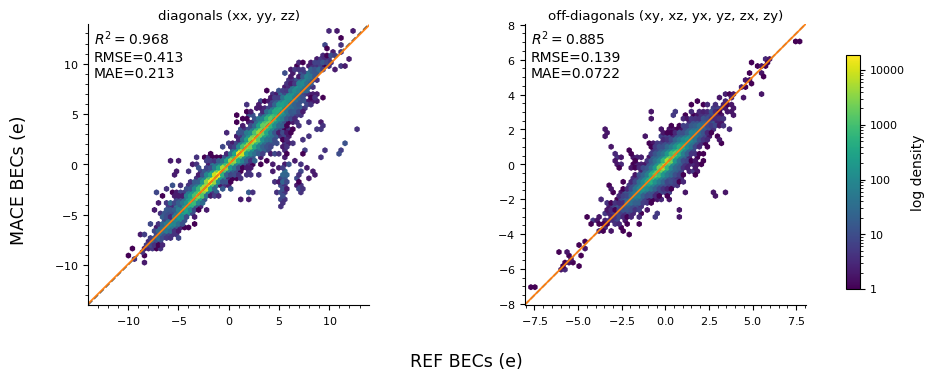

In [18]:
fig, axs = plot_bec_parity_2panel(REF_becs, MACE_becs, gridsize=70, annotate="short")
fig.savefig("plots/bec_parity_2panel_all-mh.png", bbox_inches="tight")

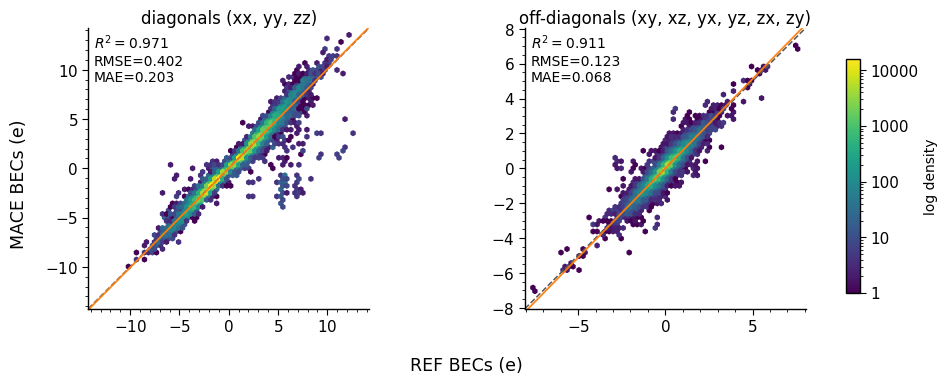

In [25]:
fig, axs = plot_bec_parity_2panel(REF_becs_train, MACE_becs_train, gridsize=70, annotate="short")
fig.savefig("plots/bec_parity_2panel_train-mh.pdf", bbox_inches="tight")

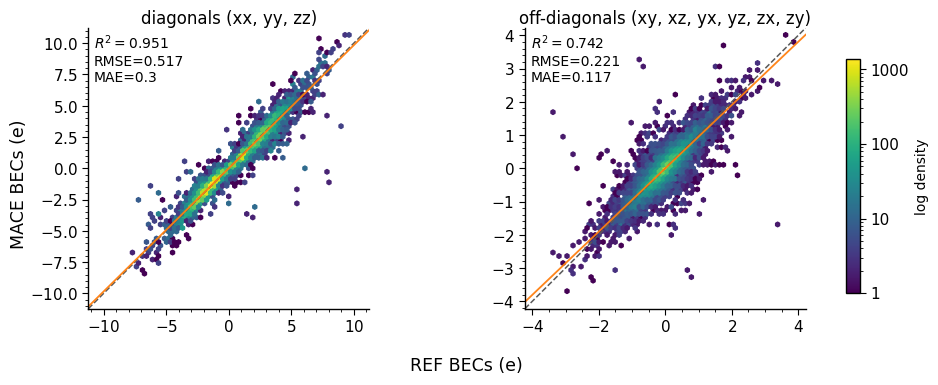

In [26]:
fig, axs = plot_bec_parity_2panel(REF_becs_valid, MACE_becs_valid, gridsize=70, annotate="short")
fig.savefig("plots/bec_parity_2panel_valid-mh.pdf", bbox_inches="tight")

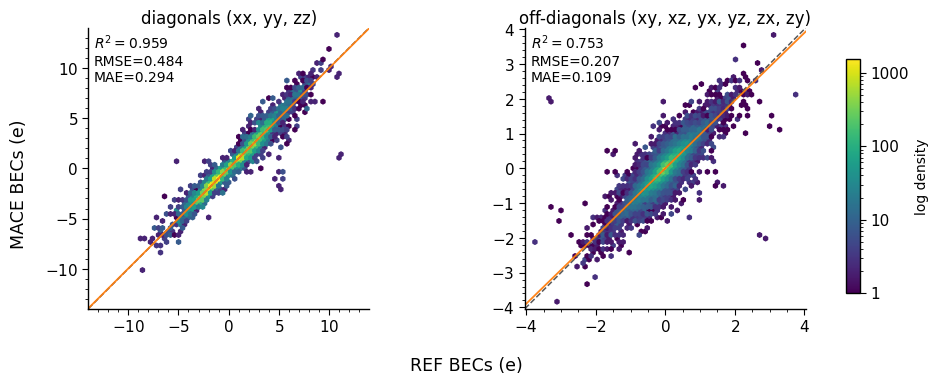

In [27]:
fig, axs = plot_bec_parity_2panel(REF_becs_test, MACE_becs_test, gridsize=70, annotate="short")
fig.savefig("plots/bec_parity_2panel_test-mh.pdf", bbox_inches="tight")

In [20]:
def plot_alpha_parity_2panel(REF_alpha, PRED_alpha, **kwargs):
    return _two_panel_parity_hex(
        REF_alpha, PRED_alpha,
        units="e/V/Å",
        diag_nonneg=True,                 # α_ii ≥ 0
        **kwargs
    )

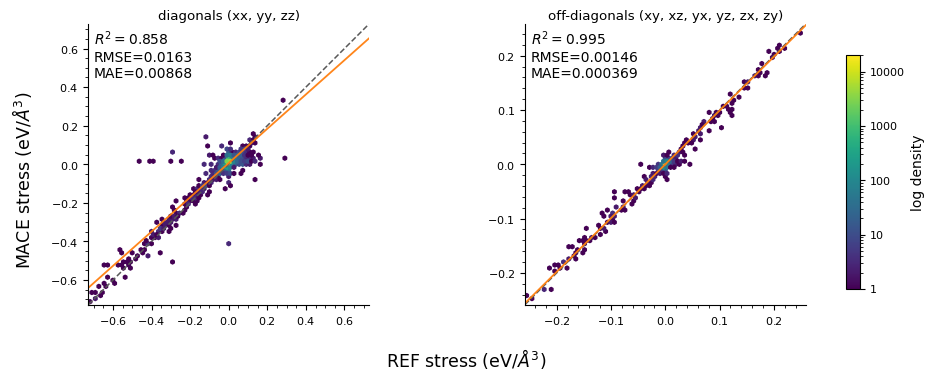

In [36]:
fig, axs = plot_stress_parity_2panel(REF_stress, MACE_stress, gridsize=80, annotate="short")

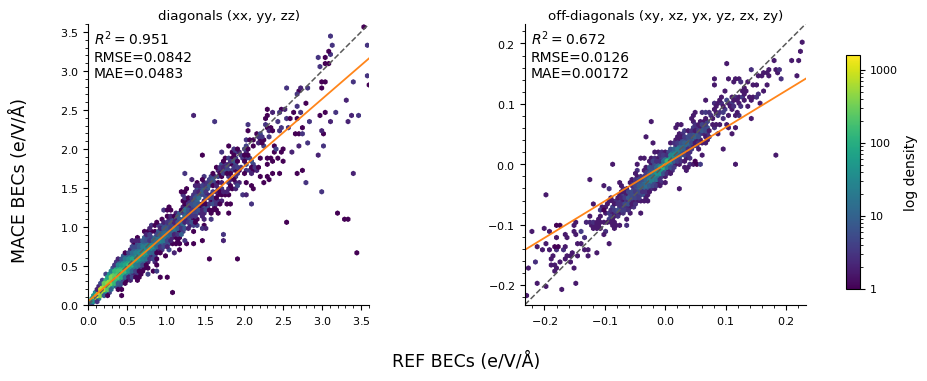

In [24]:
fig, axs = plot_alpha_parity_2panel(REF_polarisability, MACE_polarisability, gridsize=80, annotate="short", pct_limits_diag=(0.1, 99.9), pct_limits_offd=(.1, 99.9))
fig.savefig("plots/alpha_parity_2panel_all-mh.png", dpi=300, bbox_inches="tight")

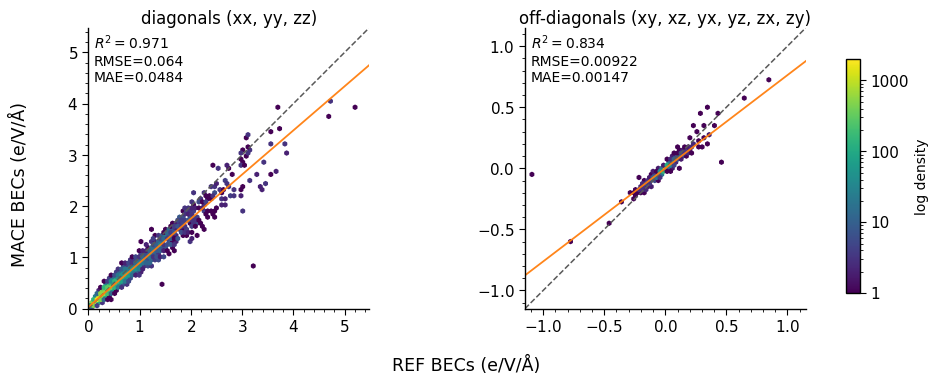

In [51]:
fig, axs = plot_alpha_parity_2panel(REF_polarisability_train, MACE_polarisability_train, gridsize=80, annotate="short", pct_limits_diag=(0, 100), pct_limits_offd=(0, 100))
fig.savefig("plots/alpha_parity_2panel_train-mh.pdf", dpi=300, bbox_inches="tight")

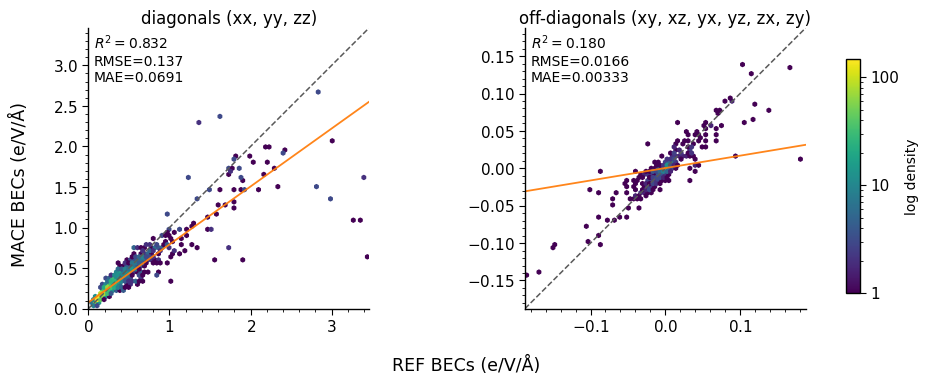

In [53]:
fig, axs = plot_alpha_parity_2panel(REF_polarisability_valid, MACE_polarisability_valid, gridsize=80, annotate="short", pct_limits_diag=(0.1, 99.9), pct_limits_offd=(0.1, 99.9))
fig.savefig("plots/alpha_parity_2panel_valid-mh.pdf", dpi=300, bbox_inches="tight")

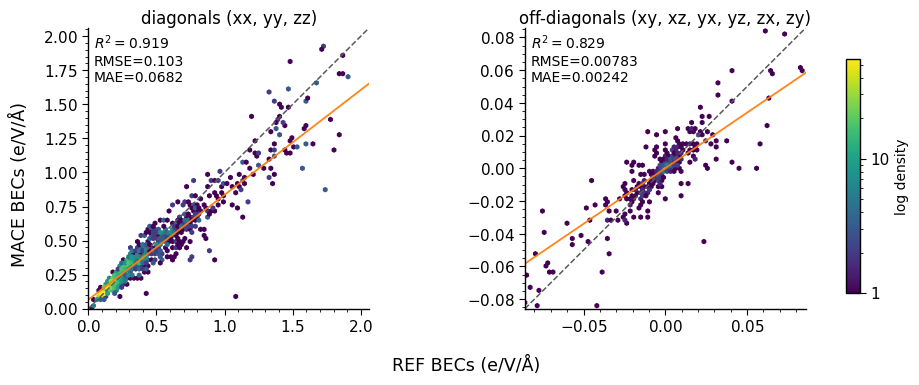

In [29]:
fig, axs = plot_alpha_parity_2panel(REF_polarisability_test, MACE_polarisability_test, gridsize=80, annotate="short", pct_limits_diag=(1, 99), pct_limits_offd=(1, 99))
fig.savefig("plots/alpha_parity_2panel_test-mh.pdf", dpi=300, bbox_inches="tight")

In [4]:
import numpy as np
import pandas as pd

# Map x/y/z chars to indices
_AXES = {"x": 0, "y": 1, "z": 2}

def _labels_to_ij(comp_labels):
    """Turn labels like ['xx','xy',...,'zz'] into [(i,j), ...]."""
    ij = []
    for lab in comp_labels:
        lab = lab.strip().lower()
        if len(lab) != 2 or lab[0] not in _AXES or lab[1] not in _AXES:
            raise ValueError(f"Bad component label: {lab!r}. Expected two letters from 'xyz'.")
        ij.append((_AXES[lab[0]], _AXES[lab[1]]))
    if len(ij) != 9:
        raise ValueError("comp_labels must have 9 entries.")
    return ij

def bec_component_table_flat(
    dataset,
    which="diag",                         # "diag" | "offdiag" | "all"
    comp_labels=None                      # order of the 9 columns in arrays["*_becs"]
):
    """
    Build a tidy DataFrame of per-atom, per-component BECs and errors
    when REF/MACE are stored as shape (n_atoms, 9).

    Parameters
    ----------
    dataset : iterable of ASE Atoms-like objects with:
              arrays["REF_becs"], arrays["MACE_becs"] of shape (n_atoms, 9)
    which : {"diag","offdiag","all"}
    comp_labels : list[str] of length 9 describing column order, e.g.
                  ['xx','xy','xz','yx','yy','yz','zx','zy','zz']  (default)

    Returns
    -------
    DataFrame with columns:
      material, atom_index, element, comp, i, j, ref, pred, resid, abs_resid, dist
    """
    # default column order (common row-major: xx,xy,xz,yx,yy,yz,zx,zy,zz)
    if comp_labels is None:
        comp_labels = ['xx','xy','xz','yx','yy','yz','zx','zy','zz']
    ij_list = _labels_to_ij(comp_labels)  # index (i,j) for each flat column 0..8

    # which columns to keep?
    if which == "diag":
        keep_cols = [k for k, (i,j) in enumerate(ij_list) if i == j]
    elif which == "offdiag":
        keep_cols = [k for k, (i,j) in enumerate(ij_list) if i != j]
    elif which == "all":
        keep_cols = list(range(9))
    else:
        raise ValueError("which must be 'diag', 'offdiag', or 'all'.")

    rows = []
    for mat in dataset:
        ref = np.asarray(mat.arrays["REF_becs"])   # (n_atoms, 9)
        pred = np.asarray(mat.arrays["MACE_becs"]) # (n_atoms, 9)
        if ref.ndim != 2 or pred.ndim != 2 or ref.shape[1] != 9 or pred.shape[1] != 9:
            raise ValueError("Expected arrays['*_becs'] with shape (n_atoms, 9).")
        if ref.shape[0] != pred.shape[0]:
            raise ValueError("REF and MACE BECs have different n_atoms.")

        for a in range(ref.shape[0]):
            el = mat[a].symbol
            for k in keep_cols:
                i, j = ij_list[k]
                r = float(ref[a, k])
                p = float(pred[a, k])
                resid = p - r
                rows.append({
                    "material": str(mat.symbols),
                    "atom_index": int(a),
                    "element": el,
                    "i": i, "j": j,
                    "comp": f"{'xyz'[i]}{'xyz'[j]}",
                    "ref": r, "pred": p,
                    "resid": resid,
                    "abs_resid": abs(resid),
                    "dist": abs(resid) / np.sqrt(2.0)  # ⟂ distance to y=x
                })
    return pd.DataFrame(rows)


# -------------------- OUTLIER IDENTIFICATION --------------------

def find_bec_outliers_flat(
    dataset,
    *,
    which="diag",
    comp_labels=None,
    tau=None,                   # absolute threshold in e (e.g., 1.5)
    top_percentile=None,        # or e.g. 99 for top 1%
    ref_range=None              # optional (lo, hi) on REF values to zoom on a region
):
    """
    Return a (outliers_df, summary_by_element) tuple for quick inspection.
    """
    df = bec_component_table_flat(dataset, which=which, comp_labels=comp_labels)

    mask = np.isfinite(df["abs_resid"])
    if ref_range is not None:
        lo, hi = ref_range
        mask &= df["ref"].between(lo, hi)

    if tau is None and top_percentile is None:
        raise ValueError("Provide either tau (absolute threshold) or top_percentile.")
    if tau is not None:
        mask &= df["abs_resid"] >= float(tau)
    else:
        thr = df.loc[mask, "abs_resid"].quantile(top_percentile/100.0)
        mask &= df["abs_resid"] >= thr

    outliers = df[mask].copy().sort_values("abs_resid", ascending=False)

    elem_summary = (
        outliers.groupby("element")
                .agg(n=("abs_resid","size"),
                     median_abs_err=("abs_resid","median"),
                     max_abs_err=("abs_resid","max"))
                .sort_values(["n","median_abs_err","max_abs_err"], ascending=[False, False, False])
    )

    return outliers, elem_summary


# -------------------- EXAMPLE USAGE --------------------
# Diagonal outliers using an absolute residual threshold:
outliers, elem_summary = find_bec_outliers_flat(
    MACE_dielectric_train_data,
    which="diag",
    comp_labels=['xx','xy','xz','yx','yy','yz','zx','zy','zz'],  # set to your real order
    tau=1.5,                           # choose a sensible value for your scale
    ref_range=(3.0, 8.0)               # optional: focus on the circled region
)
print(elem_summary.head(10))
print(outliers.loc[:,["material","atom_index","element","comp","ref","pred","abs_resid"]].head(20).to_string(index=False))

# Or: top 1% worst diagonal residuals regardless of absolute scale:
outliers, elem_summary = find_bec_outliers_flat(
    MACE_dielectric_train_data,
    which="diag",
    comp_labels=['xx','xy','xz','yx','yy','yz','zx','zy','zz'],
    top_percentile=99
)
print(elem_summary.head(10))
print(outliers.loc[:,["material","atom_index","element","comp","ref","pred","abs_resid"]].head(20).to_string(index=False))


           n  median_abs_err  max_abs_err
element                                  
O        122        7.493514     9.516721
F         83        6.738231     8.179260
Te        32        2.192617     9.736430
Si        32        1.744925     1.927349
S         22        8.209672     9.301381
Re        22        2.381765     3.122520
Se        14        7.917664     9.734118
Bi        14        1.749064     2.054790
I         13        2.051787     2.559999
As        13        1.889894     2.201254
 material  atom_index element comp     ref      pred  abs_resid
 Y2Ag2Te4           7      Te   yy 7.37016 -2.366270   9.736430
 K2Au2Se4           6      Se   xx 7.11875 -2.615368   9.734118
 K2Au2Se4           5      Se   xx 7.11875 -2.615366   9.734116
 K2Au2Se4           7      Se   xx 7.11875 -2.615364   9.734114
 K2Au2Se4           4      Se   xx 7.11875 -2.615361   9.734111
 Y2Ag2Te4           4      Te   yy 7.36704 -2.366271   9.733311
 Y2Ag2Te4           5      Te   zz 7.19527 -2.36

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter, LogFormatter

_AXES = {"x":0,"y":1,"z":2}
def _labels_to_ij(comp_labels):
    ij=[]; 
    for lab in comp_labels:
        a,b=lab.strip().lower()
        ij.append((_AXES[a], _AXES[b]))
    if len(ij)!=9: raise ValueError("comp_labels must have 9 entries.")
    return ij

def bec_component_table_flat(dataset, which="diag", comp_labels=None):
    if comp_labels is None:
        comp_labels=['xx','xy','xz','yx','yy','yz','zx','zy','zz']
    ij_list = _labels_to_ij(comp_labels)
    keep = [k for k,(i,j) in enumerate(ij_list) if (i==j if which=="diag" else i!=j)] if which!="all" else list(range(9))
    rows=[]
    for mat in dataset:
        ref = np.asarray(mat.arrays["REF_becs"])
        pred= np.asarray(mat.arrays["MACE_becs"])
        for a in range(ref.shape[0]):
            el = mat[a].symbol
            for k in keep:
                i,j = ij_list[k]
                r=float(ref[a,k]); p=float(pred[a,k]); resid=p-r
                rows.append({
                    "material": str(mat.symbols), "atom_index": int(a), "element": el,
                    "i":i,"j":j,"comp":f"{'xyz'[i]}{'xyz'[j]}",
                    "ref": r, "pred": p, "resid": resid, "abs_resid": abs(resid)
                })
    return pd.DataFrame(rows)

def _stats(x,y):
    m,c = np.polyfit(x,y,1)
    yhat=m*x+c
    ss_res=np.sum((y-yhat)**2); ss_tot=np.sum((y-np.mean(y))**2)
    r2 = 1-ss_res/ss_tot if ss_tot>0 else np.nan
    rmse=np.sqrt(np.mean((y-yhat)**2)); mae=np.mean(np.abs(y-x))
    return m,c,r2,rmse,mae

def _symmetric_limits(values, pct=(1,99)):
    v=np.concatenate([np.asarray(a).ravel() for a in values]); v=v[np.isfinite(v)]
    if v.size==0: return (-1,1)
    lo,hi=np.percentile(v,pct); L=max(abs(lo),abs(hi)); 
    if not np.isfinite(L) or L==0: L=max(1.0, np.nanmax(np.abs(v)))
    pad=0.03*L; return (-(L+pad),(L+pad))

def plot_bec_parity_with_outliers_flat(
    dataset, *,
    comp_labels=None,
    tau_diag=None, tau_off=None,
    top_pct_diag=None, top_pct_off=None,
    ref_window_diag=None, ref_window_off=None,
    units="e", gridsize=60, cmap="viridis", pct_limits=(0,100),
    annotate="short", figsize=(11.5, 5.0),
    legend_topk=12,                # show only top-K elements in legend & colored
    bar_topn=25,                   # show only top-N elements in bar chart
    label_points=True,            # annotate worst points with element symbol
    labels_per_element=2           # how many labels per element (if label_points)
):
    # tidy tables
    d_diag = bec_component_table_flat(dataset, which="diag",    comp_labels=comp_labels)
    d_off  = bec_component_table_flat(dataset, which="offdiag", comp_labels=comp_labels)
    limD = _symmetric_limits((d_diag["ref"], d_diag["pred"]), pct=pct_limits)
    limO = _symmetric_limits((d_off["ref"],  d_off["pred"]),  pct=pct_limits)

    # select outliers for each set
    def select_outliers(df, tau, top_pct, ref_window):
        m = np.isfinite(df["abs_resid"])
        if ref_window is not None:
            lo,hi = ref_window
            m &= df["ref"].between(lo,hi)
        if tau is not None:
            m &= df["abs_resid"] >= float(tau)
        elif top_pct is not None:
            thr = df.loc[m,"abs_resid"].quantile(top_pct/100.0)
            m &= df["abs_resid"] >= thr
        return df[m].copy().sort_values("abs_resid", ascending=False)

    outD = select_outliers(d_diag, tau_diag, top_pct_diag, ref_window_diag)
    outO = select_outliers(d_off,  tau_off,  top_pct_off,  ref_window_off)

    # choose top-K elements by outlier count
    both = pd.concat([outD.assign(kind="diag"), outO.assign(kind="off")], ignore_index=True)
    counts = both.groupby("element").size().sort_values(ascending=False)
    focus_elems = counts.head(legend_topk).index.tolist()

    # color map: focus_elems distinct; others light gray
    cycle = plt.rcParams.get("axes.prop_cycle").by_key().get("color", None) or \
            ["#4C78A8","#F58518","#54A24B","#E45756","#72B7B2",
             "#EECA3B","#B279A2","#FF9DA6","#9D755D","#BAB0AC"]
    elem_color = {e: cycle[i % len(cycle)] for i,e in enumerate(focus_elems)}
    OTHER_COLOR = (0.65,0.65,0.65)

    plt.rcParams.update({
        "font.size": 11, "axes.labelsize": 12.5, "axes.titlesize": 12,
        "axes.linewidth": 1.0, "legend.frameon": False,
        "xtick.direction": "out", "ytick.direction": "out",
        "xtick.major.size": 4, "ytick.major.size": 4,
    })
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 0.14])

    axD = fig.add_subplot(gs[0,0]); axO = fig.add_subplot(gs[0,1]); axB = fig.add_subplot(gs[0,2])
    cax = fig.add_subplot(gs[1,0:2])

    # --- helper to draw one panel ---
    def draw_panel(ax, df, lim, title):
        x,y = df["ref"].values, df["pred"].values
        hb = ax.hexbin(x,y, gridsize=gridsize, extent=(*lim,*lim), bins="log", cmap=cmap, mincnt=1, rasterized=True)
        ax.plot(lim, lim, "--", color="0.3", lw=1.2)
        mfit,cfit,r2,rmse,mae = _stats(x,y)
        xx = np.linspace(*lim,2); ax.plot(xx, mfit*xx+cfit, color="tab:orange", lw=1.4, alpha=0.95)
        if annotate!="none":
            txt = (fr"$R^2={r2:.3f}$" "\n" fr"RMSE={rmse:.3g}" "\n" fr"MAE={mae:.3g}")
            if annotate=="long": txt += "\n" + fr"$m={mfit:.3f}$" + "\n" + fr"$c={cfit:.3f}$"
            ax.text(0.02,0.98,txt, transform=ax.transAxes, ha="left", va="top",
                    fontsize=10, bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", boxstyle="round,pad=0.25"))
        ax.set_xlim(*lim); ax.set_ylim(*lim); ax.set_aspect("equal")
        for s in ("top","right"): ax.spines[s].set_visible(False)
        ax.xaxis.set_minor_locator(AutoMinorLocator()); ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which="minor", length=2)
        ax.set_title(title)
        ax.set_xlabel(f"REF BECs ({units})"); ax.set_ylabel(f"MACE BECs ({units})")
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        return hb

    hbD = draw_panel(axD, d_diag, limD, "diagonals (xx, yy, zz)")
    hbO = draw_panel(axO, d_off,  limO, "off-diagonals (xy, xz, yx, yz, zx, zy)")

    # --- overlay outliers: color only focus_elems, others gray
    def overlay(ax, out_df):
        if out_df.empty: return
        for e, g in out_df.groupby("element"):
            col = elem_color.get(e, OTHER_COLOR)
            ax.scatter(g["ref"], g["pred"], s=30, facecolors="none", edgecolors=col, linewidths=1.6, zorder=5, label=e)
            if label_points and e in focus_elems:
                # annotate a few largest residuals for this element
                gg = g.nlargest(labels_per_element, "abs_resid")
                for _,r in gg.iterrows():
                    ax.annotate(e, (r["ref"], r["pred"]), xytext=(3,3), textcoords="offset points",
                                fontsize=8, color=col, weight="bold")
        # small legend with only focus_elems
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            # keep only desired ones
            keep = [(h,l) for h,l in zip(handles, labels) if l in focus_elems]
            if keep:
                h,l = zip(*keep)
                ax.legend(h, l, title="Top outlier elements", loc="lower right", ncol=2)

    overlay(axD, outD); overlay(axO, outO)

    # shared colorbar
    cb = fig.colorbar(hbO, cax=cax, orientation="horizontal")
    cb.set_label("log density"); cb.formatter = LogFormatter(10, labelOnlyBase=False); cb.update_ticks()

    # bar chart: top elements only
    if both.empty:
        axB.text(0.5,0.5,"No outliers\nwith current thresholds", ha="center", va="center"); axB.set_axis_off()
    else:
        top_counts = counts.head(bar_topn).sort_values(ascending=True)
        cols = [elem_color.get(e, OTHER_COLOR) for e in top_counts.index]
        axB.barh(np.arange(len(top_counts)), top_counts.values, color=cols)
        axB.set_yticks(np.arange(len(top_counts))); axB.set_yticklabels(top_counts.index, fontsize=8)
        axB.set_xlabel("# outlier components"); axB.set_title("elements among outliers")
        for s in ("top","right"): axB.spines[s].set_visible(False)

    fig.suptitle("BEC parity with outlier identification", y=1.02, fontsize=13)
    return fig, (axD, axO, axB), {"diag_outliers": outD, "off_outliers": outO}


material  atom_index element comp       ref      pred  abs_resid
242113    Cs4H4O4           1      Cs   yy  11.01410  1.062542   9.951558
242119    Cs4H4O4           3      Cs   yy  11.01410  1.062543   9.951557
242116    Cs4H4O4           2      Cs   yy  11.01355  1.062541   9.951009
242110    Cs4H4O4           0      Cs   yy  11.01355  1.062542   9.951008
237192  Cs4Li6F10           3      Cs   xx  11.01738  1.117555   9.899825
237186  Cs4Li6F10           1      Cs   xx  11.01738  1.117563   9.899817
237188  Cs4Li6F10           1      Cs   zz  11.01738  1.198896   9.818484
237194  Cs4Li6F10           3      Cs   zz  11.01738  1.198901   9.818479
96754    Y2Ag2Te4           7      Te   yy   7.37016 -2.366270   9.736430
222687   K2Au2Se4           6      Se   xx   7.11875 -2.615368   9.734118
222684   K2Au2Se4           5      Se   xx   7.11875 -2.615366   9.734116
222690   K2Au2Se4           7      Se   xx   7.11875 -2.615364   9.734114
222681   K2Au2Se4           4      Se   xx   7.11875 -2.615361   9.734111
96745    Y2Ag2Te4           4      Te   yy   7.36704 -2.366271   9.733311
237183  Cs4Li6F10           0      Cs   xx  11.01629  1.329931   9.686359
237189  Cs4Li6F10           2      Cs   xx  11.01629  1.329932   9.686358
237185  Cs4Li6F10           0      Cs   zz  11.01629  1.381981   9.634309
237191  Cs4Li6F10           2      Cs   zz  11.01629  1.381982   9.634308
191350  Ba4Mn4F16           2      Ba   yy  11.66515  2.031244   9.633906
191347  Ba4Mn4F16           1      Ba   yy  11.66515  2.031245   9.633905

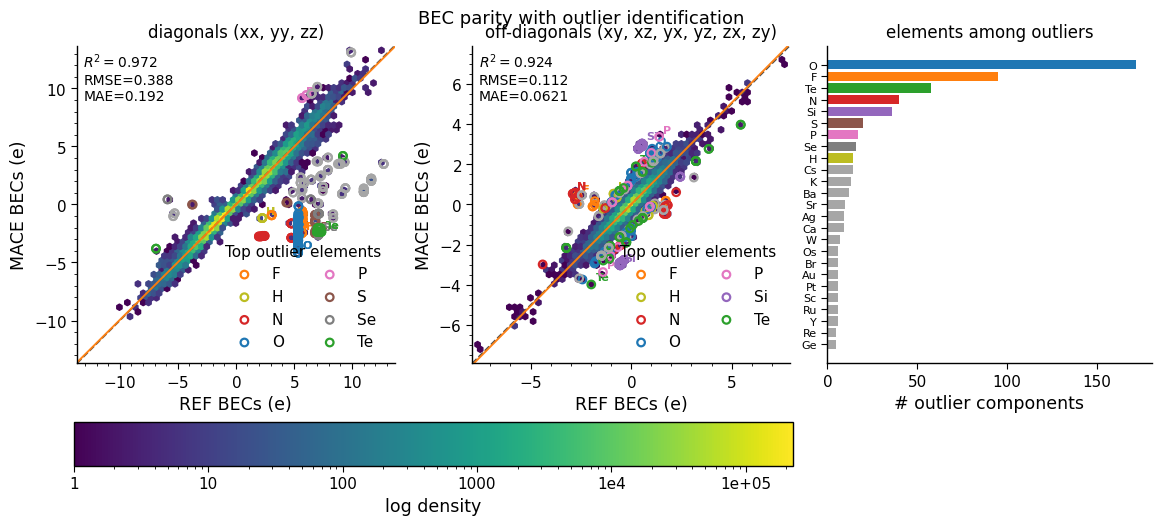

In [172]:
# Diagonals: show outliers ≥ 1.5 e, Off-diagonals: top 1% worst
fig, axes, out = plot_bec_parity_with_outliers_flat(
    MACE_dielectric_train_data,
    comp_labels=['xx','xy','xz','yx','yy','yz','zx','zy','zz'],  # set to your column order
    tau_diag=3,
    top_pct_off=99.95,
    units="e",
    annotate="short",
    legend_topk=9
)

# Inspect the actual rows (material, atom, component) that were highlighted:
out["diag_outliers"].loc[:, ["material","atom_index","element","comp","ref","pred","abs_resid"]].head(20)


In [9]:
def top_material_error_table_wide(
    dataset,
    outliers,
    *,
    which="diag",
    comp_labels=None,
    top_n=20,
    max_elements=4,
    agg="mean",
):
    """
    Wide table of top erroneous *materials*.

    - One row per material (no duplicates).
    - For each material, we pick a *single* most offending component
      (largest |resid| in `outliers` for that material).
    - For that component, we list each unique element once, aggregated
      over all atoms of that element:
          Element 1: element / ref / pred
          Element 2: element / ref / pred
          ...
      where Element 1 is the worst element in that material+component.

    Parameters
    ----------
    dataset : same as for bec_component_table_flat
    outliers : DataFrame returned by find_bec_outliers_flat
    which, comp_labels : MUST match the call used for outliers
    top_n : how many materials to keep (by worst abs_resid)
    max_elements : max number of element-groups (Element 1..N) per row
    agg : 'mean' | 'median' | 'max' over atoms of same element

    Returns
    -------
    DataFrame with MultiIndex columns:
      ("", "material"), ("", "component"), ("", "max_abs_resid"),
      ("Element 1", "element"), ("Element 1", "ref"), ("Element 1", "pred"),
      ("Element 2", "element"), ("Element 2", "ref"), ("Element 2", "pred"), ...
    """

    # Full per-atom table (same settings as for outliers)
    df_all = bec_component_table_flat(dataset, which=which, comp_labels=comp_labels)

    if outliers.empty:
        return pd.DataFrame()

    # For each material, pick the single most offending row from the outliers
    idx = outliers.groupby("material")["abs_resid"].idxmax()
    best_rows = outliers.loc[idx].copy()

    # Rank materials by worst abs_resid
    best_rows = best_rows.sort_values("abs_resid", ascending=False)
    if top_n is not None:
        best_rows = best_rows.head(top_n)

    # Keep material / component / max_abs_resid
    best_rows = best_rows.rename(columns={"comp": "component"})
    best_rows = best_rows[["material", "component", "abs_resid"]].rename(
        columns={"abs_resid": "max_abs_resid"}
    )

    # Align df_all with the chosen (material, component) pairs
    pairs = best_rows[["material", "component"]]
    df_sel = df_all.merge(
        pairs.rename(columns={"component": "comp"}),
        on=["material", "comp"],
        how="inner",
    )
    if df_sel.empty:
        return pd.DataFrame()

    # Aggregate over atoms of same element in material+component
    if agg == "mean":
        agg_dict = dict(ref=("ref", "mean"), pred=("pred", "mean"), abs_resid=("abs_resid", "mean"))
    elif agg == "median":
        agg_dict = dict(ref=("ref", "median"), pred=("pred", "median"), abs_resid=("abs_resid", "median"))
    elif agg == "max":
        agg_dict = dict(ref=("ref", "max"), pred=("pred", "max"), abs_resid=("abs_resid", "max"))
    else:
        raise ValueError("agg must be 'mean', 'median' or 'max'.")

    per_el = (
        df_sel.groupby(["material", "comp", "element"])
              .agg(**agg_dict)
              .reset_index()
    )

    # Rank elements within each (material, comp) by their abs_resid
    per_el = per_el.sort_values(["material", "comp", "abs_resid"],
                                ascending=[True, True, False])
    per_el["el_rank"] = per_el.groupby(["material", "comp"]).cumcount() + 1

    # Limit to at most `max_elements` per material
    per_el = per_el[per_el["el_rank"] <= max_elements]

    # Build wide rows with MultiIndex columns for sub-headings
    rows = []
    for _, main_row in best_rows.iterrows():
        mat = main_row["material"]
        comp = main_row["component"]
        max_err = main_row["max_abs_resid"]

        sub = per_el[(per_el["material"] == mat) & (per_el["comp"] == comp)]
        sub = sub.sort_values("el_rank")

        row_dict = {
            ("", "material"): mat,
            ("", "component"): comp,
            ("", "max_abs_resid"): max_err,
        }

        for _, el_row in sub.iterrows():
            k = int(el_row["el_rank"])
            group = f"Element {k}"
            row_dict[(group, "element")] = el_row["element"]
            row_dict[(group, "ref")] = el_row["ref"]
            row_dict[(group, "pred")] = el_row["pred"]

        rows.append(row_dict)

    if not rows:
        return pd.DataFrame()

    # Collect all column tuples and enforce nice ordering
    col_tuples = set()
    for r in rows:
        col_tuples.update(r.keys())

    def col_sort_key(col):
        grp, sub = col
        if grp == "":
            grp_order = 0
        elif grp.startswith("Element "):
            try:
                grp_order = int(grp.split()[1])
            except Exception:
                grp_order = 999
        else:
            grp_order = 998
        sub_order_map = {
            "material": 0,
            "component": 1,
            "max_abs_resid": 2,
            "element": 0,
            "ref": 1,
            "pred": 2,
        }
        sub_order = sub_order_map.get(sub, 99)
        return (grp_order, sub_order, grp, sub)

    ordered_cols = sorted(col_tuples, key=col_sort_key)
    columns = pd.MultiIndex.from_tuples(ordered_cols)

    df_wide = pd.DataFrame(rows)
    df_wide = df_wide.reindex(columns=columns)

    return df_wide


In [11]:
# First, build outlier set as before
outliers, elem_summary = find_bec_outliers_flat(
    MACE_dielectric_train_data,
    which="diag",
    comp_labels=['xx','xy','xz','yx','yy','yz','zx','zy','zz'],
    tau=1.5,
    ref_range=(3.0, 8.0),
)

# Then, one-row-per-material wide table
mat_wide = top_material_error_table_wide(
    MACE_dielectric_train_data,
    outliers,
    which="diag",
    comp_labels=['xx','xy','xz','yx','yy','yz','zx','zy','zz'],
    top_n=30,       # top 30 worst materials
    max_elements=4, # Element 1/2/3 (good for ternary)
    agg="mean",
)

                                     Element 1                      Element 2  \
    material component max_abs_resid   element        ref      pred   element   
0   Y2Ag2Te4        yy      9.736430        Te   7.171378 -2.366270         Y   
1   K2Au2Se4        xx      9.734118        Se   7.118750 -2.615365         K   
2  Sm4Ta4O16        yy      9.516721         O   5.361769 -2.751053        Sm   
3    Ca2SnS4        zz      9.301381         S   6.824480 -2.401662        Ca   
4  La4Ta4O16        yy      9.171551        La  12.735870  3.486075         O   
5    CdPt3O6        xx      9.122973         O   5.391697 -1.830910        Pt   
6    MgPt3O6        xx      9.037582         O   5.385390 -2.032118        Pt   
7    Bi2O2F2        xx      8.995697         O   5.388520 -3.607176         F   
8  Tm4Ta4O16        yy      8.868436         O   5.359248 -2.933121        Tm   
9    ZnPt3O6        xx      8.861450         O   5.391503 -1.837132        Pt   

                      Eleme

In [15]:
# Optionally prettify column names a bit
mat_latex = mat_wide.copy()

# Rename the scalar columns to nicer LaTeX labels
mat_latex = mat_latex.rename(
    columns={
        ("", "material"): ("", "Material"),
        ("", "component"): ("", "Comp."),
        ("", "max_abs_resid"): ("", r"$|Z^* - \hat Z^*|_\mathrm{max}$"),
    }
)

# (Optional) rename element subcolumns too
for k in ["Element 1", "Element 2", "Element 3"]:
    if (k, "element") in mat_latex.columns:
        mat_latex = mat_latex.rename(
            columns={
                (k, "element"): (k, "Element"),
                (k, "ref"):     (k, r"$Z^*_\mathrm{DFT}$"),
                (k, "pred"):    (k, r"$Z^*_\mathrm{ML}$"),
            }
        )

latex_str = mat_latex.to_latex(
    index=False,
    escape=False,           # allow LaTeX in column names
    multicolumn=True,       # use \multicolumn for "Element 1/2/3"
    multicolumn_format="c", # center group headings
    column_format="l l r | l r r | l r r | l r r",  # adjust as you like
    float_format="%.3f"
)

print(latex_str)


\begin{tabular}{l l r | l r r | l r r | l r r}
\toprule
\multicolumn{3}{c}{} & \multicolumn{3}{c}{Element 1} & \multicolumn{3}{c}{Element 2} & \multicolumn{3}{c}{Element 3} \\
material & component & max_abs_resid & element & ref & pred & element & ref & pred & element & ref & pred \\
\midrule
Y2Ag2Te4 & yy & 9.736 & Te & 7.171 & -2.366 & Y & 8.915 & 3.486 & Ag & 5.692 & 1.247 \\
K2Au2Se4 & xx & 9.734 & Se & 7.119 & -2.615 & K & 7.515 & 1.524 & Au & 7.082 & 3.707 \\
Sm4Ta4O16 & yy & 9.517 & O & 5.362 & -2.751 & Sm & 9.361 & 3.656 & Ta & 7.648 & 7.349 \\
Ca2SnS4 & zz & 9.301 & S & 6.824 & -2.402 & Ca & 7.356 & 2.498 & Sn & 6.491 & 4.610 \\
La4Ta4O16 & yy & 9.172 & La & 12.736 & 3.486 & O & 5.364 & -2.937 & Ta & 7.648 & 8.261 \\
CdPt3O6 & xx & 9.123 & O & 5.392 & -1.831 & Pt & 6.941 & 2.572 & Cd & 6.143 & 3.270 \\
MgPt3O6 & xx & 9.038 & O & 5.385 & -2.032 & Pt & 6.947 & 3.148 & Mg & 3.821 & 2.748 \\
Bi2O2F2 & xx & 8.996 & O & 5.389 & -3.607 & F & 5.731 & -1.786 & Bi & 6.588 & 5.393 \\
Tm4

In [16]:
with open("bec_outliers_table.tex", "w") as f:
    f.write(latex_str)

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

def analyze_asr_from_xyz(
    xyz_path,
    tol=1.0,        # tolerance in e
    bins=40,
    xmax=None,      # optional explicit x-limit (0..xmax); if None, use full range
    savefig=None,   # e.g. "asr_log_hist.png"
):
    """
    Analyze ASR violations from a .xyz with REF_becs and plot a single
    log-scale histogram of the ASR deviation per structure (counts, not density).

    Parameters
    ----------
    xyz_path : str or Path
        Path to the .xyz file containing multiple structures, each with
        arrays["REF_becs"] of shape (n_atoms, 9) or (n_atoms, 3, 3).
    tol : float
        Tolerance on max |sum_i Z*_{i,alpha,beta}| (in e) to consider ASR obeyed.
    bins : int
        Number of bins for the histogram.
    xmax : float or None
        If not None, set x-axis to [0, xmax]. Otherwise use full data range.
    savefig : str or None
        If not None, path to save the figure.

    Returns
    -------
    obey_asr : list[ase.Atoms]
    violate_asr : list[ase.Atoms]
    max_devs : np.ndarray  shape (n_structures,)
    """

    # ---- Load data and compute ASR deviation per structure ----
    traj = read(xyz_path, ":")

    max_devs = []
    for at in traj:
        becs = np.asarray(at.arrays["REF_becs"])

        if becs.ndim == 2 and becs.shape[1] == 9:
            becs = becs.reshape(-1, 3, 3)
        elif becs.ndim == 3 and becs.shape[1:] == (3, 3):
            pass
        else:
            raise ValueError(
                f"Unexpected REF_becs shape {becs.shape}; "
                "expected (n_atoms, 9) or (n_atoms, 3, 3)."
            )

        total_bec = becs.sum(axis=0)       # (3,3)
        max_dev = np.abs(total_bec).max()  # scalar
        max_devs.append(max_dev)

    max_devs = np.asarray(max_devs)

    obey_mask = max_devs <= tol
    obey_asr = [at for at, ok in zip(traj, obey_mask) if ok]
    violate_asr = [at for at, ok in zip(traj, obey_mask) if not ok]

    print(f"Total structures: {len(traj)}")
    print(f"Obey ASR (max dev <= {tol} e): {obey_mask.sum()}")
    print(f"Violate ASR: {len(traj) - obey_mask.sum()}")
    print(f"Max deviation overall: {max_devs.max():.3f} e")

    # ---- Plot: single log-scale histogram (counts) ----
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(max_devs, bins=bins, alpha=0.7)   # no density=True -> raw counts
    ax.axvline(tol, linestyle="--", label=f"tol = {tol:.3g} e")

    if xmax is not None:
        ax.set_xlim(0.0, xmax)
    else:
        ax.set_xlim(0.0, max_devs.max() * 1.05)

    ax.set_yscale("log")
    ax.set_ylim(0,10)
    ax.set_xlabel(r"max$_{\alpha\beta}\,|\sum_i Z^*_{i,\alpha\beta}|$ [e]")
    ax.set_ylabel("Count (log scale)")
    ax.set_title("ASR deviation per structure")
    ax.legend()
    fig.tight_layout()

    if savefig is not None:
        fig.savefig(savefig, dpi=300)

    return obey_asr, violate_asr, max_devs


Total structures: 5946
Obey ASR (max dev <= 0.05 e): 5501
Violate ASR: 445
Max deviation overall: 167.361 e


/tmp/ipykernel_1547462/2877694445.py:80: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,10)


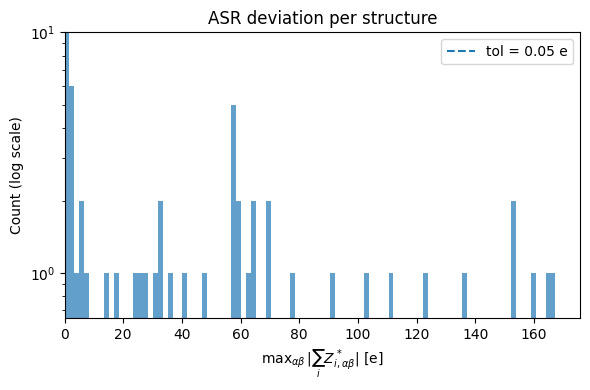

In [88]:
obey, violate, devs = analyze_asr_from_xyz(
    "dielectric_corrected.xyz",
    tol=0.05, 
    bins=100,
    savefig="asr_histogram.png",
)

In [89]:
from ase.io import write
write("dielectric_corrected_asr.xyz", obey)

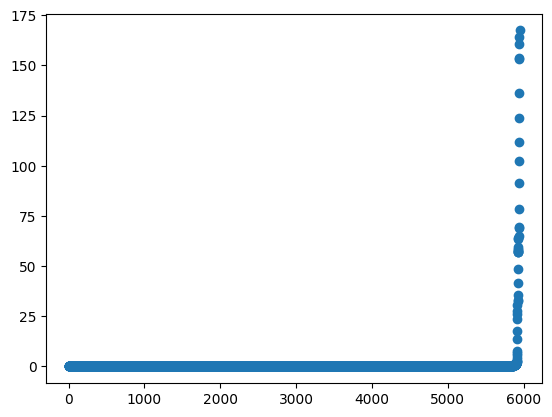

In [51]:
plt.scatter(range(len(devs)), devs)

In [52]:
violate[4].arrays['REF_becs'].reshape(-1,3,3)

array([[[ 6.58813e+00, -2.58620e-01,  6.60000e-04],
        [-2.58460e-01,  6.58813e+00,  6.60000e-04],
        [ 0.00000e+00,  0.00000e+00,  4.12404e+00]],

       [[ 6.58813e+00, -2.58620e-01, -6.60000e-04],
        [-2.58460e-01,  6.58813e+00, -6.60000e-04],
        [ 0.00000e+00,  0.00000e+00,  4.12366e+00]],

       [[ 5.38852e+00,  7.33540e-01,  9.00000e-04],
        [ 7.33410e-01,  5.38852e+00, -9.00000e-04],
        [ 0.00000e+00,  0.00000e+00, -1.84171e+00]],

       [[ 5.38852e+00,  7.33540e-01, -9.00000e-04],
        [ 7.33410e-01,  5.38852e+00,  9.00000e-04],
        [ 0.00000e+00,  0.00000e+00, -1.84171e+00]],

       [[ 5.73052e+00,  1.75280e-01, -2.40000e-04],
        [ 1.75240e-01,  5.73052e+00,  2.50000e-04],
        [ 0.00000e+00,  0.00000e+00, -2.28292e+00]],

       [[ 5.73052e+00,  1.75280e-01,  2.40000e-04],
        [ 1.75240e-01,  5.73052e+00, -2.50000e-04],
        [ 0.00000e+00,  0.00000e+00, -2.28292e+00]]])

In [75]:
devs[-1:-600:-1]

array([1.6736104e+02, 1.6410158e+02, 1.6051282e+02, 1.5382496e+02,
       1.5339798e+02, 1.3608346e+02, 1.2357718e+02, 1.1170242e+02,
       1.0221030e+02, 9.1142160e+01, 7.8462000e+01, 6.9462400e+01,
       6.9189000e+01, 6.4974320e+01, 6.3923010e+01, 6.3380210e+01,
       5.9315340e+01, 5.8673680e+01, 5.7899110e+01, 5.7668720e+01,
       5.7030390e+01, 5.6974050e+01, 5.6952440e+01, 4.8501890e+01,
       4.1363620e+01, 3.5414340e+01, 3.3034880e+01, 3.2624740e+01,
       3.0735130e+01, 2.7726490e+01, 2.6116140e+01, 2.3616810e+01,
       1.7719260e+01, 1.3924410e+01, 7.7652800e+00, 6.6916600e+00,
       5.5817700e+00, 4.1990800e+00, 2.6868000e+00, 2.6745700e+00,
       2.3164800e+00, 2.2714800e+00, 1.8872000e+00, 1.8035200e+00,
       1.6227600e+00, 1.2896800e+00, 1.2494600e+00, 1.2179600e+00,
       1.1963000e+00, 1.0992000e+00, 1.0474600e+00, 1.0397200e+00,
       1.0239800e+00, 1.0015500e+00, 1.0008500e+00, 9.4799000e-01,
       9.4777000e-01, 9.3343000e-01, 8.5850000e-01, 8.1757000e